# Reproduce Figure 1 for global

In [1]:
%cd /home/rguillaume/developpements/Publications/2025_Guillaume-Castel_Ceppi_PatternEffect-Variability

/home/rguillaume/developpements/Publications/2025_Guillaume-Castel_Ceppi_PatternEffect-Variability


# Imports

In [2]:
#---------- System imports
import os
from tqdm.notebook import tqdm

#---------- Analysis imports
import numpy as np
import xarray as xr 
import pandas as pd

import xeofs # https://github.com/xarray-contrib/xeofs
import xesmf as xe # https://xesmf.readthedocs.io/en/stable/
from xarrayutils import  xr_linregress # https://github.com/jbusecke/xarrayutils
import lenapy # https://github.com/CNES/lenapy
from sklearn.cross_decomposition import PLSRegression
from scipy.interpolate import griddata

 
#---------- Plotting imports
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeat
import seaborn.objects as so
from matplotlib.font_manager import fontManager
import cmocean.cm as cmo

#---------- Plotting styles
plt.style.use('./robin.mplstyle')
color_palette_enso = ["#56B4E9",  "#E69F00", "#D55E00","#0072B2"]
fontManager.addfont('./Arial.ttf')
fontManager.addfont('./Arial-bold.ttf')
plt.rcParams['font.sans-serif'] = 'Arial'


# Preprocessing
Before this analysis, both SST data and Green's Functions are regridded to a 2degree grid, which corresponds to the coarsest SST product. 
SST are regridded using bilnear interpolation and GF are regridded using a conservative regridding both with `xesmf`.

In [3]:
#---------- Data paths

SST_DIR = '/projets/EMC2/data/Observations/SST/'
# ERSSTv5 from https://psl.noaa.gov/data/gridded/data.noaa.ersst.v5.html
# COBE2 from https://psl.noaa.gov/data/gridded/data.cobe2.html 
# HadISST from  https://www.metoffice.gov.uk/hadobs/hadisst/data/download.html (HadISST_sst.nc.gz)

GF_DIR = '/projets/EMC2/data/Models/GFMIP/preliminary_spatial_feedbacks-main/data/'
# GF from https://github.com/GFMIP/preliminary_spatial_feedbacks/tree/main/data

OCEAN_MASK_PATH = '/home/rguillaume/developpements/Publications/2025_Guillaume-Castel_Ceppi_PatternEffect-Variability/RECCAP2_region_masks_all_v20221025.nc'
# Mask from https://github.com/RECCAP2-ocean/R2-shared-resources/blob/master/data/regions/RECCAP2_region_masks_all_v20221025.nc

## Preprocess SST

/home/rguillaume/virtual_envs/phd/lib/python3.10/site-packages/gribapi/__init__.py:23: UserWarning: ecCodes 2.31.0 or higher is recommended. You are running version 2.16.0
  warnings.warn(


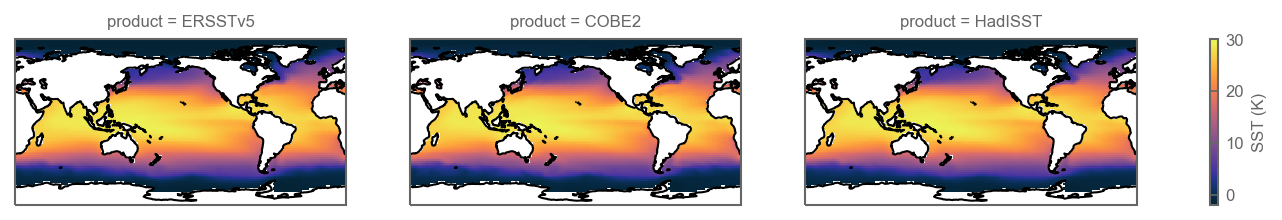

In [4]:

grid_out_2deg = xr.Dataset({'lat': (['lat'], np.arange(-89, 90, 2.)),
                            'lon': (['lon'], np.arange(1, 360, 2.))})


#---------- Load files and regridding
products_file_name = dict(ERSSTv5='ERSSTv5',COBE2='COBE2',HadISST_sst='HadISST')
products_ds = []
for file in products_file_name:
    with xr.open_dataset(f'{SST_DIR}/{file}.nc') as ds_in:
        if 'HadISST' in file:
            null_mask = ((ds_in['sst'].notnull())).isel(time=0)
            ds_in['sst'] = ds_in['sst'].where((ds_in['sst']>-100), -1.8)
            ds_in['sst'] = ds_in['sst'].where(null_mask)
        regridder = xe.Regridder(ds_in, grid_out_2deg, 'bilinear', periodic=True)
        ds_out = regridder(ds_in).sst
        ds_out = ds_out.assign_coords(time=pd.date_range(f"{ds_out.time.dt.year.values[0]}-{ds_out.time.dt.month.values[0]}",freq='MS', periods=ds_out.time.size))
        ds_out = ds_out.assign_coords(product=products_file_name[file])
        products_ds.append(ds_out)

ds_tos = xr.concat(products_ds,dim='product')
ds_tos = ds_tos.squeeze().drop_vars('lev')
ds_tos = ds_tos.sortby('lat', ascending=False)

ds_tos = ds_tos.where(ds_tos.count('product')==ds_tos.count('product').max())

#---------- Load files and regridding

ds_mask = xr.open_dataset(OCEAN_MASK_PATH).open_ocean
mask = ds_mask.interp_like(ds_tos.isel(time=0, product=0, drop=True), method='nearest')

# # Remove climatology and make anomalies
ds_tos_clim = ds_tos.sel(time=slice('1960','2024')).lntime.climato(trend=False, mean=False).load()
ds_tos_clim_ref = ds_tos_clim.sel(time=slice('1960', '1980')).mean('time')
ds_tos_anom = ds_tos_clim - ds_tos_clim_ref
ds_tos_anom_mean = ds_tos_anom.weighted(np.cos(np.deg2rad(ds_tos_anom.lat))).mean(['lon','lat'])
SSTA = ds_tos_anom - ds_tos_anom_mean
# Remove trend and acceleration from spatial anomaly field
SSTA_detrend = SSTA - xr.polyval(SSTA.time, SSTA.polyfit('time', deg=2).polyfit_coefficients)
# Remove trend and acceleration from full field
ds_tos_clim_detrend  = ds_tos_clim - xr.polyval(ds_tos_clim.time, ds_tos_clim.polyfit('time', deg=2).polyfit_coefficients)

# extract pacific data only
SSTA_pac = SSTA_detrend.where(mask.isin([2]), drop=True)


SSTA_pac = SSTA_detrend

plot = ds_tos.mean('time').plot(col='product', subplot_kws=dict(projection=ccrs.PlateCarree(200)), size=1.5, aspect=2, transform=ccrs.PlateCarree(), cmap = cmo.thermal,
                                cbar_kwargs=dict(label="SST (K)"), vmin=-2, vmax=30)
for ax in plot.axs.flatten():
    ax.coastlines()

## Preprocess Green's Functions

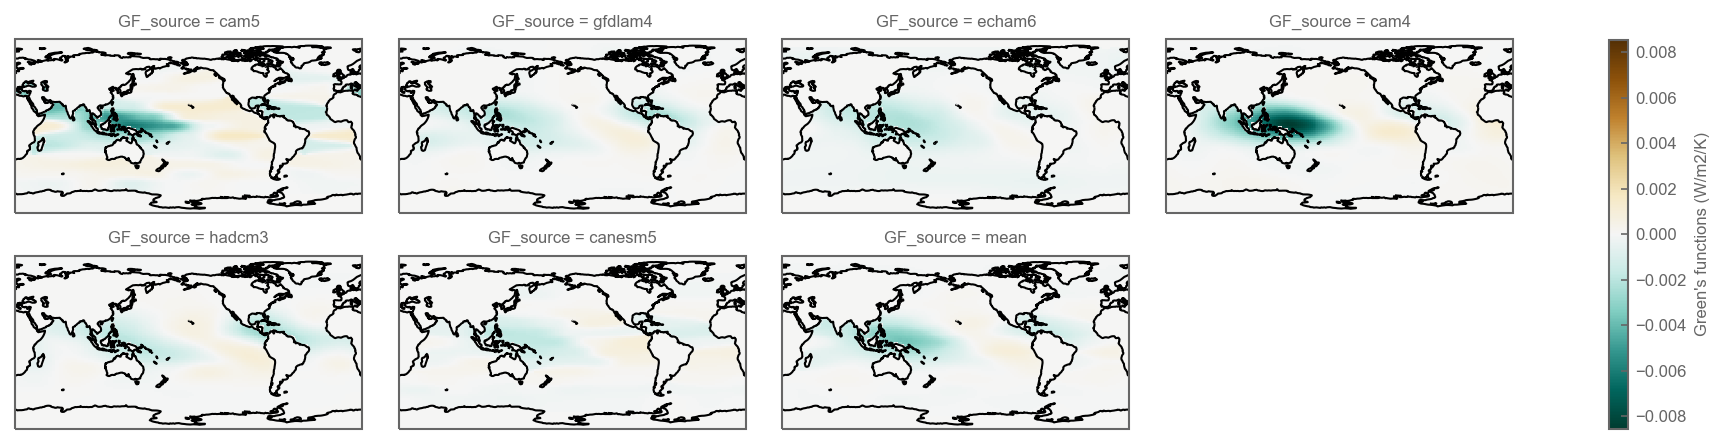

In [5]:
#---------- Load files and regridding

GF_names = dict(cam4='CAM4',cam5='CAM5', canesm5='CanESM5', echam6='ECHAM6', gfdlam4='GFDL-AM4',hadcm3='HadCM3')

list_gfs = [k.split('.')[0] for k in os.listdir(GF_DIR)]
all_gfs = []
for gf in list_gfs:
    ds = xr.open_dataset(f"{GF_DIR}/{gf}.nc").rename(longitude='lon', latitude='lat')
    if gf == 'hadcm3':
        ds = ds.assign_coords(latitude_bnds=ds.latitude_bnds.where(np.abs(ds.latitude_bnds)!=90, -ds.latitude_bnds))
    if gf=='cam4':
        da = ds.spatial_feedbacks_from_warming
    else:
        da = ds.spatial_feedbacks_from_both
    ds['mask'] = (da!=0).astype(int)
    regridder_gf = xe.Regridder(ds, grid_out_2deg, 'conservative_normed', periodic=True)
    GF_regridded = regridder_gf(da).assign_coords(GF_source=gf)
    all_gfs.append(GF_regridded)

GF = xr.concat(all_gfs, dim='GF_source')
GF = GF.where(GF!=0)
# Add mean GF
GF = xr.concat([GF, GF.mean('GF_source').assign_coords(GF_source='mean')], dim='GF_source')

# fill in continents/island gaps with bilinear interpolation
def fill2d(arr, x, y):
    xx, yy = np.meshgrid(x, y)
    points = np.column_stack((xx.ravel(), yy.ravel()))
    mask = ~np.isnan(arr.ravel())
    return griddata(points[mask], arr.ravel()[mask], points, method="linear").reshape(arr.shape)

GF_filled = xr.apply_ufunc(
    fill2d, GF.where(GF!=0), GF.lon, GF.lat,
    input_core_dims=[["lat","lon"], ["lon"], ["lat"]],
    output_core_dims=[["lat","lon"]],
    vectorize=True,
    dask="parallelized",
)


GF = GF_filled

#---------- multiply by fraction of ocean area

cell_area = (xr.zeros_like(ds_tos.isel(product=0, time=0, drop=True))+np.cos(np.deg2rad(ds_tos.lat))).where(ds_tos.isel(product=0, time=1000, drop=True).notnull()).fillna(0)
cell_ratio = cell_area/cell_area.sum(['lon','lat'])
GF_normed = (GF*cell_ratio).fillna(0)
GF = GF_normed

plot = GF.plot(col='GF_source', subplot_kws=dict(projection=ccrs.PlateCarree(200)), size=1.5, aspect=2, col_wrap=4, transform=ccrs.PlateCarree(), cmap = 'BrBG_r',
cbar_kwargs=dict(label="Green's functions (W/m2/K)"))
for ax in plot.axs.flatten():
    ax.coastlines()



# Processing

## Compute ENSO indices


In [6]:
def get_eof(data, n_modes=3):
    model = xeofs.models.EOF(n_modes=n_modes, use_coslat=True)
    model.fit(data, dim='time')
    components = model.components().persist()
    variance_explained = model.explained_variance_ratio().persist()*100
    timeseries = model.fit_transform(data, dim='time', normalized=False).persist()
    del components.attrs['solver_kwargs']
    del variance_explained.attrs['solver_kwargs']
    return xr.Dataset(dict(components=components, 
                           timeseries=timeseries, 
                           variance_explained=variance_explained))

def get_eof_gf(data, gf, n_modes=3):
    eof = get_eof(data*gf, n_modes=n_modes)
    eof['components_sst'] = eof.components/gf
    eof['pe'] = (eof.components*eof.timeseries).sum(['lon','lat'])
    eof['pe_total'] = (data*gf).sum(['lon','lat'])
    eof['variance_explained_pe'] = eof.pe.var('time')/eof.pe_total.var('time')*100
    return eof


In [7]:
#---------- Compute time series indices


# EP CP ENSO from https://icar.nuist.edu.cn/en/NlNinoIndices/listm.psp
nino34_bounds = {"lat": slice(5, -5), "lon": slice(190, 240)}  # 160°E to 150°W
nino3_bounds = {"lat": slice(5, -5), "lon": slice(210, 270)}  # 150°W to 90°W
nino4_bounds = {"lat": slice(5, -5), "lon": slice(160, 210)}  # 160°E to 150°W

nino34 = ds_tos_clim.sel(nino34_bounds).weighted(np.cos(np.deg2rad(ds_tos_clim.lat))).mean(['lon','lat']) 
nino3 = ds_tos_clim.sel(nino3_bounds).weighted(np.cos(np.deg2rad(ds_tos_clim.lat))).mean(['lon','lat'])
nino4 = ds_tos_clim.sel(nino4_bounds).weighted(np.cos(np.deg2rad(ds_tos_clim.lat))).mean(['lon','lat'])
alpha = xr.ones_like(nino3).where(nino3*nino4>0,0)*2/5

# Ren and Jin
EP = nino3 - alpha*nino4
CP = nino4 - alpha*nino3

# Takahashi

eofs_trop_pac_SST = xr.concat([get_eof(ds_tos_clim.where(mask==2).sel(product=product).sel(lat=slice(10,-10))).timeseries \
                                for product in tqdm(SSTA_pac.product)], dim='product')
eofs_trop_pac_SST.loc[dict(mode=2)] = -eofs_trop_pac_SST.sel(mode=2)

eofs_trop_pac_SST = eofs_trop_pac_SST/eofs_trop_pac_SST.std('time')
pc1 = eofs_trop_pac_SST.isel(mode=0)
pc2 = eofs_trop_pac_SST.isel(mode=1)


modes = xr.concat([nino34.assign_coords(mode='nino34'),
                   CP.assign_coords(mode='CP'),
                   EP.assign_coords(mode='EP'),
                   pc2.assign_coords(mode='modoki'),
                   ], dim='mode')


# smooth with 1-2-1 filter as in takahashi
w = xr.DataArray([0.25, 0.5, 0.25], dims=["window"])

modes_smooth = (
    modes
    .rolling(time=3, center=True, min_periods=3)
    .construct(time="window")
    .dot(w)  # contracts over "window"
).dropna('time')

# Re standardize
modes_smooth = modes_smooth/modes_smooth.std('time')

#---------- Spatial patterns

# Compute spatial patterns
regr_modes = xr_linregress(modes_smooth, SSTA_pac, dim='time')

#---------- Normalize
lambdas_space = regr_modes.slope.weighted(np.cos(np.deg2rad(regr_modes.lat))).std(['lon','lat'])
patterns_no_std = regr_modes.slope / lambdas_space
lambdas = lambdas_space 

modes_obs = xr.Dataset(dict(mode_pattern=regr_modes.slope,
                           mode_timeseries=modes_smooth,
                           lambdas_space=lambdas_space,
                           lambdas=lambdas))
modes_obs['pi'] = (modes_obs.mode_pattern/modes_obs.lambdas_space*GF).sum(['lon','lat'])


  0%|          | 0/3 [00:00<?, ?it/s]

## Compute Rp

In [8]:
Rp_total = (SSTA_detrend*GF).sum(['lon','lat'])
Rp_pac = (SSTA_pac*GF).sum(['lon','lat'])

Rp_pac = Rp_total
Rp_all_basins =(SSTA_detrend*GF).transpose('lat','lon',...).groupby(mask.fillna(0)).sum(['lon','lat']).assign_coords(open_ocean=['none','Atlantic','Pacific','Indian','Arctic','Southern'])
Rp_all_basins = Rp_all_basins.drop_sel(open_ocean='none')

## Compute EOFs

In [9]:
all_eofs = []
for product in tqdm(SSTA_pac.product):
    all_eofs_product = []
    for GF_source in tqdm(GF.GF_source):
        eof_pac_gf = get_eof_gf(SSTA_pac.sel(product=product).fillna(0).sortby('lat'), GF.sel(GF_source=GF_source).fillna(0),n_modes=20).assign_coords(GF_source=GF_source)
        all_eofs_product.append(eof_pac_gf)
    eofs_pac_product = xr.concat(all_eofs_product, dim='GF_source').assign_coords(product=product)
    eofs_pac_product = eofs_pac_product.rename(dict(components="components",
                                    timeseries="timeseries",
                                    variance_explained="variance_explained",
                                    components_sst="components_sst",
                                    pe="pe",
                                    pe_total="pe_total_eofs_pac",
                                    variance_explained_pe="variance_explained_pe_eofs_pac",))
    all_eofs.append(eofs_pac_product)

# smooth with 1-2-1 filter as in takahashi
all_eofs_pac = xr.concat(all_eofs, dim='product')

all_eofs_pac['timeseries'] = (
    all_eofs_pac.timeseries
    .rolling(time=3, center=True, min_periods=3)
    .construct(time="window")
    .dot(w)  # contracts over "window"
).dropna('time')

all_eofs_pac['components_sst'] = all_eofs_pac['components_sst'].where(np.isfinite(all_eofs_pac['components_sst']))

# Normalize all patters by sign and amplitude
sign_eof = np.sign(all_eofs_pac.components_sst.sel(lon=200, lat=0, method='nearest'))
sign_eof.loc[dict(mode=2)] = -np.sign(all_eofs_pac.components_sst.sel(mode=2).where(all_eofs_pac.lat>50).mean(['lon','lat']))
sign_eof.loc[dict(mode=2, product='ERSSTv5')] = np.sign(all_eofs_pac.components_sst.sel(mode=2, product='ERSSTv5', lon =slice(245,250), lat=slice(-5,5)).mean(['lon','lat']))
sign_eof.loc[dict(mode=3)] = -sign_eof.loc[dict(mode=3)]
sign_eof.loc[dict(mode=2)] = -sign_eof.loc[dict(mode=2)]
sign_eof.loc[dict(mode=3, product='HadISST', GF_source='echam6')] = -sign_eof.loc[dict(mode=3, product='HadISST', GF_source='echam6')]



# # If doing global !!
sign_eof.loc[dict(mode=1)] = np.sign(all_eofs_pac.components_sst.sel(mode=1, lon =slice(245,250), lat=slice(-5,5)).mean(['lon','lat']))
# sign_eof.loc[dict(mode=3, GF_source='echam6')] = np.sign(all_eofs_pac.components_sst.sel(mode=1,GF_source='echam6', lon =slice(260,300), lat=slice(-5,5)).mean(['lon','lat']))
# #######

lbd_timeseries = all_eofs_pac.timeseries.std('time')
lbd_pattern = all_eofs_pac.components_sst.weighted(np.cos(np.deg2rad(all_eofs_pac.lat))).std(['lon','lat'])

amplitude_eofs = sign_eof/lbd_pattern
all_eofs_pac['timeseries'] = all_eofs_pac['timeseries']*sign_eof/lbd_timeseries
all_eofs_pac[['components_sst','components']] =all_eofs_pac[['components_sst','components']]*sign_eof/lbd_pattern
all_eofs_pac['lambdas'] = lbd_pattern*lbd_timeseries
all_eofs_pac['pi'] = (all_eofs_pac.components_sst*GF).sum(['lon','lat'])
all_eofs_pac = all_eofs_pac.rename(mode='feature')

all_eofs_pac[['components','components_sst','pi']] = all_eofs_pac[['components','components_sst','pi']]#*np.sign(all_eofs_pac.pi)

eofs_pac = all_eofs_pac.isel(feature=np.arange(3))

eofs_pac['lambdas_scaled'] = eofs_pac.lambdas/Rp_pac.std('time')

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

## Compute PLSR

In [10]:
all_output = []
for product in SSTA_pac.product.values:
    pattern = SSTA_pac.sel(product=product, drop=True)
    all_product = []
    for gf_choice in tqdm(GF.GF_source):
        GF_mean = GF.sel(GF_source=gf_choice, drop=True)
        X = pattern#*GF_mean
        Y = Rp_pac.sel(GF_source=gf_choice, product=product)
        X = X.sel(time=Y.time)

        weights_X = xr.ones_like(X)*np.cos(np.deg2rad(GF.lat))
        X = X.stack(space=['lon','lat'])
        weights_X = weights_X.stack(space=['lon','lat'])
        X = X.dropna('space')
        weights_X = weights_X.sel(space=X.space)
        
        n_components = 20
        pls2 = PLSRegression(n_components=n_components, scale=False)
        pls2.fit(X*weights_X, Y)

        components =  xr.DataArray(pls2.x_loadings_[:]/weights_X.isel(time=range(n_components), drop=True).T, dims=['space','mode'], coords=dict(space=X.space)).unstack().sortby(['lon','lat']).transpose('mode','lat','lon')        
        timeseries =  xr.DataArray(pls2.x_scores_, dims=['time','mode'], coords=dict(time=X.time))
        components_sst = components
        components = components_sst*GF_mean
        ds_out_one = xr.Dataset(dict(components_sst=components_sst,
                                     components=components,
                                     timeseries=timeseries)).assign_coords(product=product, GF_source=gf_choice)
        ds_out_one['pe'] = (ds_out_one.components.sum(['lon','lat'])*ds_out_one.timeseries)
        all_product.append(ds_out_one)
    ds_product = xr.concat(all_product, dim='GF_source').assign_coords(mode=np.arange(1,21))
    all_output.append(ds_product)
all_plsr_pac = xr.concat(all_output, dim='product')

all_plsr_pac['timeseries'] = (
    all_plsr_pac.timeseries
    .rolling(time=3, center=True, min_periods=3)
    .construct(time="window")
    .dot(w)  # contracts over "window"
).dropna('time')

# Normalize all patters b sign and apmlitude
sign_plsr = np.sign(all_plsr_pac.components_sst.sel(lon=200, lat=0, method='nearest'))
sign_plsr.loc[dict(mode=3)] = -np.sign(all_plsr_pac.components_sst.sel(mode=3).where(all_plsr_pac.lat>50).mean(['lon','lat']))

lbd_timeseries = all_plsr_pac.timeseries.std('time')
lbd_pattern = all_plsr_pac.components_sst.weighted(np.cos(np.deg2rad(all_plsr_pac.lat))).std(['lon','lat'])

all_plsr_pac['timeseries'] = all_plsr_pac['timeseries']*sign_plsr/lbd_timeseries
all_plsr_pac[['components_sst','components']] =all_plsr_pac[['components_sst','components']]*sign_plsr/lbd_pattern
all_plsr_pac['lambdas'] = lbd_pattern*lbd_timeseries
all_plsr_pac['pi'] = (all_plsr_pac.components_sst*GF).sum(['lon','lat'])
all_plsr_pac = all_plsr_pac.rename(mode='feature')

sign_pi = np.sign(all_plsr_pac.pi)
sign_pi.loc[dict(feature=2)] = -sign_pi.loc[dict(feature=2)]

all_plsr_pac[['components','components_sst','pi','timeseries']] = all_plsr_pac[['components','components_sst','pi','timeseries']]*sign_pi

plsr_pac = all_plsr_pac.isel(feature=np.arange(3))


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

# Main Figures

## Figure 1: maps of modes

In [11]:
df_1 = eofs_pac[['pi','lambdas']].to_dataframe()
df_1['dRp_var'] = Rp_pac.var('time').to_series()
df_1['method']='EOFs'

df_2 = plsr_pac[['pi','lambdas']].to_dataframe()
df_2['dRp_var'] = Rp_pac.var('time').to_series()
df_2['method']='PLSR'

df = pd.concat([df_1,df_2])

df['lambdas_scaled'] = df.lambdas/np.sqrt(df.dRp_var)
df['lambdas_scaled_squared'] = df.lambdas**2/df.dRp_var
df['pi_scaled'] = df.pi/np.sqrt(df.dRp_var)
df['pi_scaled_squared'] = df.pi**2/df.dRp_var

df['lambdas_squared'] = df.lambdas**2
df['pi_squared'] = df.pi**2
df['sigmaRp'] = np.sqrt(df.dRp_var)
df['abs_pi'] = np.abs(df.pi)
df['var_explained'] = 100*df.pi_squared*df.lambdas_squared/df.dRp_var
df['x_value'] = df.lambdas**2/df.dRp_var
df['y_value'] = df.abs_pi**2


df_mean = df.groupby(['feature','method']).mean(numeric_only=True)
df_mean['var_explained'] = 100*(df_mean.pi_squared*df_mean.lambdas_squared/df_mean.dRp_var)
df_mean['x_value'] = df_mean.lambdas_squared/df_mean.dRp_var
df_mean['y_value'] = df_mean.pi_squared





df_modes_obs = xr.merge([Rp_total.var('time').rename('dRp_var'), modes_obs[['pi','lambdas']]]).to_dataframe()


df_modes_obs['lambdas_scaled'] = df_modes_obs.lambdas/np.sqrt(df_modes_obs.dRp_var)
df_modes_obs['lambdas_scaled_squared'] = df_modes_obs.lambdas**2/df_modes_obs.dRp_var
df_modes_obs['pi_scaled'] = df_modes_obs.pi/np.sqrt(df_modes_obs.dRp_var)
df_modes_obs['pi_scaled_squared'] = df_modes_obs.pi**2/df_modes_obs.dRp_var

df_modes_obs['lambdas_squared'] = df_modes_obs.lambdas**2
df_modes_obs['pi_squared'] = df_modes_obs.pi**2
df_modes_obs['sigmaRp'] = np.sqrt(df_modes_obs.dRp_var)
df_modes_obs['abs_pi'] = np.abs(df_modes_obs.pi)
df_modes_obs['var_explained'] = 100*df_modes_obs.pi_squared*df_modes_obs.lambdas_squared/df_modes_obs.dRp_var
df_modes_obs['x_value'] = df_modes_obs.lambdas**2/df_modes_obs.dRp_var
df_modes_obs['y_value'] = df_modes_obs.abs_pi**2


df_modes_obs_mean = df_modes_obs.groupby(['mode']).mean(numeric_only=True)
df_modes_obs_mean['var_explained'] = 100*(df_modes_obs_mean.pi_squared*df_modes_obs_mean.lambdas_squared/df_modes_obs_mean.dRp_var)
df_modes_obs_mean['x_value'] = df_modes_obs_mean.lambdas_squared/df_modes_obs_mean.dRp_var
df_modes_obs_mean['y_value'] = df_modes_obs_mean.pi_squared

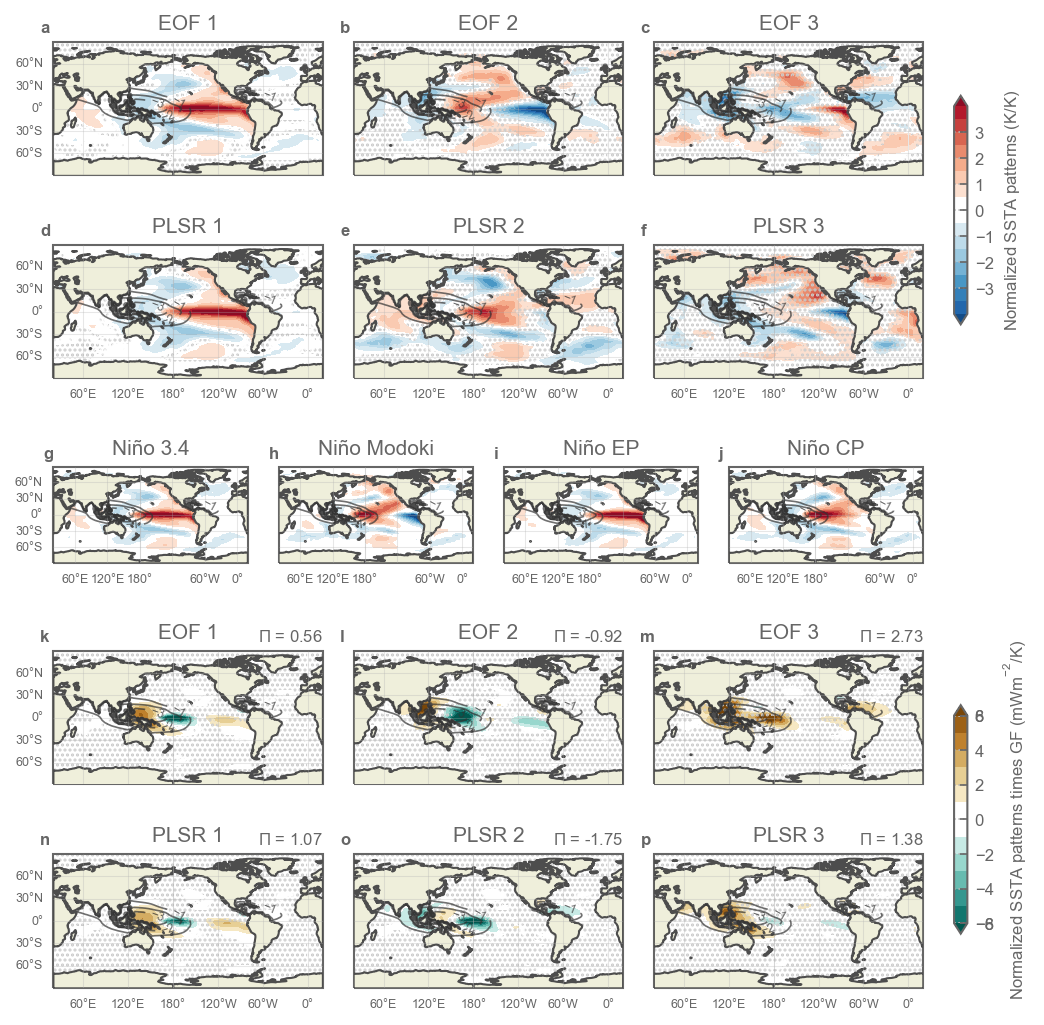

In [13]:
mean_eofs = eofs_pac.mean(['GF_source','product'])
mean_plsr = plsr_pac.mean(['GF_source','product'])

fig, axs = plt.subplot_mosaic("""
                              AAAABBBBCCCCy
                              DDDDEEEEFFFFy
                              MMMNNNOOOPPP.
                              GGGGHHHHIIIIx
                              JJJJKKKKLLLLx
                              """,
                              figsize=(7,7),
                              width_ratios=[5,5,5,5,5,5,5,5,5,5,5,5,1.5],
                              height_ratios=[10,10,10,10,10],
                              per_subplot_kw=dict(ABCDEFGHIJKLMNOP=dict(projection=ccrs.PlateCarree(200))))
palette_sst=sns.color_palette('RdBu_r',n_colors=18)
palette_sst[8] = (1,1,1)
palette_sst[9] = (1,1,1)
palette_gf=sns.color_palette('BrBG_r',n_colors=14)
palette_gf[6] = (1,1,1)
palette_gf[7] = (1,1,1)
palette_gf

axs_sst_eof = ['A','B','C']
axs_sst_plsr = ['D','E','F']
axs_modes = ['M','N','O','P']
axs_gf_eof = ['G','H','I']
axs_gf_plsr = ['J','K','L']
all_axs= axs_sst_eof+axs_sst_plsr+axs_modes+axs_gf_eof+axs_gf_plsr

levels_gf = np.arange(-6,6.1, 1)
levels_sst = np.arange(-4,4.1,.5) 


mean_eofs = eofs_pac.mean(['GF_source','product'])
mean_plsr = plsr_pac.mean(['GF_source','product'])
mean_gf = GF.sel(GF_source='mean', lon=mean_eofs.lon, lat=mean_eofs.lat)

mean_eofs['components_sst'] = (mean_eofs['components_sst']/mean_eofs['components_sst'].weighted(np.cos(np.deg2rad(mean_eofs.lat))).std(['lon','lat']))
mean_eofs['components'] = mean_eofs.components_sst*mean_gf
mean_plsr['components_sst'] = (mean_plsr['components_sst']/mean_plsr['components_sst'].weighted(np.cos(np.deg2rad(mean_plsr.lat))).std(['lon','lat']))
mean_plsr['components'] = mean_plsr.components_sst*mean_gf

sign_agreement_eof = (np.abs(np.sign(eofs_pac.components_sst).sum(['product','GF_source']))>18)
sign_agreement_plsr = (np.abs(np.sign(plsr_pac.components_sst).sum(['product','GF_source']))>18)

sign_agreement_eof_gf = (np.abs(np.sign(eofs_pac.components).sum(['product','GF_source']))>18)
sign_agreement_plsr_gf = (np.abs(np.sign(plsr_pac.components).sum(['product','GF_source']))>18)

plt.rcParams['hatch.color'] = '.8'
for k in range(3):
    
    (1000*mean_eofs.components).sel(feature=k+1).plot.contourf(ax=axs[axs_gf_eof[k]], transform=ccrs.PlateCarree(), levels=levels_gf, cbar_ax=axs['x'], extend='both', colors=palette_gf)
    (mean_eofs.components_sst.sel(feature=k+1)).plot.contourf(ax=axs[axs_sst_eof[k]], transform=ccrs.PlateCarree(), levels=levels_sst, cbar_ax=axs['y'], extend='both', colors=palette_sst)
    sign_agreement_eof.sel(feature=k+1).plot.contourf(hatches=['.....', '', ''], alpha=0, ax=axs[axs_sst_eof[k]], transform=ccrs.PlateCarree(), add_colorbar=False, )
    sign_agreement_eof_gf.sel(feature=k+1).plot.contourf(hatches=['.....', '', ''], alpha=0, ax=axs[axs_gf_eof[k]], transform=ccrs.PlateCarree(), add_colorbar=False, )

    (1000*mean_plsr.components).sel(feature=k+1).plot.contourf(ax=axs[axs_gf_plsr[k]], transform=ccrs.PlateCarree(), levels=levels_gf, cbar_ax=axs['x'], extend='both', colors=palette_gf)
    (mean_plsr.components_sst.sel(feature=k+1)).plot.contourf(ax=axs[axs_sst_plsr[k]], transform=ccrs.PlateCarree(), levels=levels_sst, cbar_ax=axs['y'], extend='both', colors=palette_sst)
    sign_agreement_plsr.sel(feature=k+1).plot.contourf(hatches=['.....', '', ''], alpha=0, ax=axs[axs_sst_plsr[k]], transform=ccrs.PlateCarree(), add_colorbar=False, )
    sign_agreement_plsr_gf.sel(feature=k+1).plot.contourf(hatches=['.....', '', ''], alpha=0, ax=axs[axs_gf_plsr[k]], transform=ccrs.PlateCarree(), add_colorbar=False, )


modes_pattern_mean = modes_obs.mode_pattern.mean('product')
modes_pattern_mean = modes_pattern_mean/modes_pattern_mean.weighted(np.cos(np.deg2rad(mean_plsr.lat))).std(['lon','lat'])

modes_pattern_mean.sel(mode='nino34').plot.contourf(ax=axs['M'], transform=ccrs.PlateCarree(), levels=levels_sst, add_colorbar=False, extend='both', colors=palette_sst)
(modes_pattern_mean.sel(mode='modoki')).plot.contourf(ax=axs['N'], transform=ccrs.PlateCarree(), levels=levels_sst, add_colorbar=False, extend='both', colors=palette_sst)
modes_pattern_mean.sel(mode='EP').plot.contourf(ax=axs['O'], transform=ccrs.PlateCarree(), levels=levels_sst, add_colorbar=False, extend='both', colors=palette_sst)
(modes_pattern_mean.sel(mode='CP')).plot.contourf(ax=axs['P'], transform=ccrs.PlateCarree(), levels=levels_sst, add_colorbar=False, extend='both', colors=palette_sst)

axs['x'].set_yticks(np.arange(-8,8.1, 2))
axs['y'].set_yticks(np.arange(-3,3.1,1))
axs['x'].minorticks_off()
axs['y'].minorticks_off()
axs['x'].set_ylabel(r'Normalized $SSTA$ patterns times $GF$ (mWm$^{-2}/K$)')
axs['y'].set_ylabel(r'Normalized $SSTA$ patterns (K/K)')

for k,letter in enumerate(all_axs):
    ax=axs[letter]
    ax.add_feature(cfeat.LAND, edgecolor='.3', zorder=100)
    ax.set_title('')
    c = (mean_gf.sel(lon=mean_eofs.lon, lat=mean_eofs.lat)*1000).plot.contour(levels=[-4,-3,-2,-1,1], extend='both', ax=ax, 
                                                                          zorder=1000, colors='.2', transform=ccrs.PlateCarree(),
                                                                          linewidths=.8, linestyles=['-','-','-','-','--'], alpha=.7)
    ax.clabel(c, c.levels, fmt=None, fontsize=6)
    gl = ax.gridlines(draw_labels=True, alpha=.3, linestyle='-', zorder=100, lw=.5)
    if letter not in axs_gf_plsr+axs_sst_plsr+axs_modes:
        gl.bottom_labels=False
    if True:
        gl.top_labels=False
    if letter not in ['A','D','M','G','J']:
        gl.left_labels=False
    gl.ylabel_style=dict(size=6)
    gl.xlabel_style=dict(size=6)
    label = chr(ord('a')+k)
    ax.text(-.05,1.05, label, weight='bold', ha='left', va='bottom', transform=ax.transAxes)
    ax.set_ylabel('')

    
for k, letter in enumerate(axs_gf_eof):
    ax=axs[letter]
    df_modes_obs.pi
    ax.text(1,1.05, r"$\Pi$"+f" = {mean_eofs.pi.isel(feature=k).values:.02f}", weight='normal', ha='right', va='bottom', transform=ax.transAxes)
for k, letter in enumerate(axs_gf_plsr):
    ax=axs[letter]
    ax.text(1,1.05, r"$\Pi$"+f" = {mean_plsr.pi.isel(feature=k).values:.02f}", weight='normal', ha='right', va='bottom', transform=ax.transAxes)

for k,letters in enumerate(zip(axs_sst_eof,axs_sst_plsr,axs_gf_eof,axs_gf_plsr)):
    a,b,c,d = letters
    axs[a].set_title(f'EOF {k+1}')
    axs[b].set_title(f'PLSR {k+1}')
    axs[c].set_title(f'EOF {k+1}')
    axs[d].set_title(f'PLSR {k+1}')


axs['M'].set_title('Niño 3.4')
axs['N'].set_title('Niño Modoki')
axs['O'].set_title('Niño EP')
axs['P'].set_title('Niño CP')
plt.tight_layout()


plt.savefig('plots_SI/maps_features_with_modes_global.svg', dpi=300)


## Figure 2: Comparison with ENSO

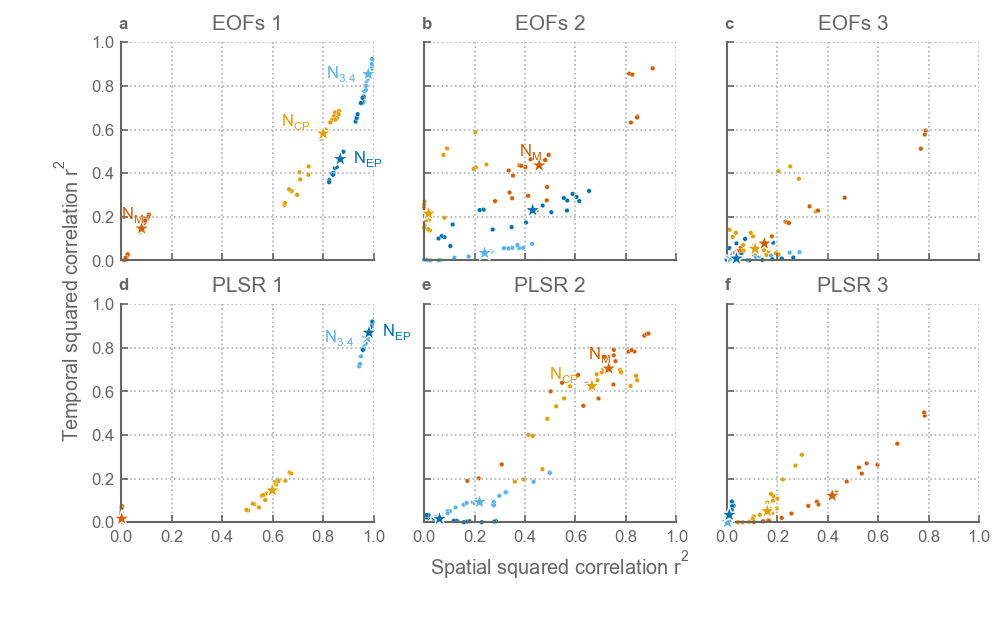

In [34]:
ds_features = xr.concat([eofs_pac.assign_coords(method='EOFs'), plsr_pac.assign_coords(method='PLSR')], dim='method')
temp_regr = xr_linregress(modes,ds_features.timeseries)
space_regr1 = xr_linregress(regr_modes.slope,ds_features.components_sst, dim=['lon','lat']).r_value
space_regr = xr.corr(regr_modes.slope,ds_features.components_sst, dim=['lon','lat'], weights = np.cos(np.deg2rad(regr_modes.lat)))

regr_both = xr.Dataset(dict(regr_space=space_regr,regr_time=temp_regr.r_value))
df_regr_mean = ((regr_both**2).median(['GF_source','product']).to_dataframe()).reset_index()
df_regr_mean['feature'] = 'Feature '+df_regr_mean['feature'].astype(str) 

df_regr_all = ((regr_both).to_dataframe()).reset_index()
df_regr_all['feature'] = 'Feature '+df_regr_all['feature'].astype(str) 

fig, axs = plt.subplots(2,3, figsize=(6.5, 4), sharex=True, sharey=True)

for k, ax in enumerate(axs.flatten()):
    feature = k%3
    method = k//3
    regr_plot = regr_both.sel(mode=['nino34','CP','EP' ,'modoki']).isel(method=method, feature=feature)**2
    df_ = regr_plot.to_dataframe().reset_index()
    df_mean = regr_plot.median(['GF_source', 'product']).to_dataframe().reset_index()
    sns.scatterplot(df_,x='regr_space',y='regr_time', ax=ax, hue='mode', s=5, legend=False, alpha=1,edgecolor='1', clip_on=False, palette=[color_palette_enso[0],color_palette_enso[1],color_palette_enso[3],color_palette_enso[2]])
    sns.scatterplot(df_mean,x='regr_space',y='regr_time', ax=ax, hue='mode', s=70, zorder=100, clip_on=False, marker='*', edgecolor='1', palette=[color_palette_enso[0],color_palette_enso[1],color_palette_enso[3],color_palette_enso[2]])
    ax.set(xlim=(0,1), ylim=(0,1))
    ax.set(xlabel='', ylabel='')
    ax.set_title(f"{regr_plot.method.values} {feature+1}")
    ax.legend().remove()
    if k in [0,3]:
        ax.text(df_mean.iloc[0].regr_space-.05, df_mean.iloc[0].regr_time, 'N$_{3.4}$', color=color_palette_enso[0], ha='right', va='center',zorder=100)
        ax.text(df_mean.iloc[2].regr_space+.05, df_mean.iloc[2].regr_time, 'N$_{EP}$', color=color_palette_enso[3], ha='left', va='center',zorder=100)
    if k in [0,4]:
        ax.text(df_mean.iloc[1].regr_space-.05, df_mean.iloc[1].regr_time+0.05, 'N$_{CP}$', color=color_palette_enso[1], ha='right', va='center',zorder=100)
    if k in [0,1,4]:
        ax.text(df_mean.iloc[3].regr_space+.01, df_mean.iloc[3].regr_time+0.06, 'N$_{M}$', color=color_palette_enso[2], ha='right', va='center',zorder=100)
    ax.text(-.01, 1.05, chr(ord('a')+k), transform=ax.transAxes, ha='left', va='bottom', weight='bold')
    
fig.supxlabel('Spatial squared correlation r$^2$',y=0.03, x=.55)
fig.supylabel('Temporal squared correlation r$^2$', x=0.03, ha='left')

plt.subplots_adjust(left=.1, bottom=.13, right=0.98, top=.93)

plt.savefig('plots/Correlation_features_with_modes.pdf')

## Figure 3: Contribution to Pattern Effect

/home/rguillaume/virtual_envs/phd/lib/python3.10/site-packages/xarray/plot/dataarray_plot.py:2134: UserWarning: linewidths is ignored by contourf
  primitive = ax.contourf(x, y, z, **kwargs)


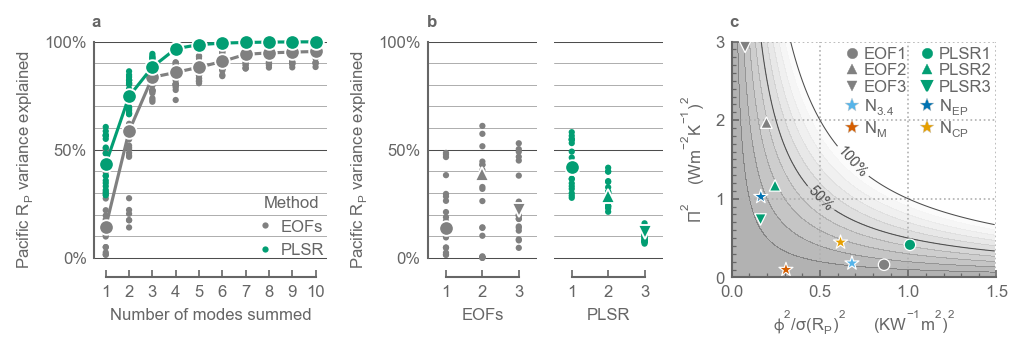

In [35]:

fig, axs = plt.subplot_mosaic("""
                              ABCD
                              """, figsize=(7,2.4), 
                              gridspec_kw=dict(width_ratios=[3,1,1,3])
                              )

df_1 = eofs_pac[['pi','lambdas']].to_dataframe()
df_1['dRp_var'] = Rp_pac.var('time').to_series()
df_1['method']='EOFs'

df_2 = plsr_pac[['pi','lambdas']].to_dataframe()
df_2['dRp_var'] = Rp_pac.var('time').to_series()
df_2['method']='PLSR'

df = pd.concat([df_1,df_2])

df['lambdas_scaled'] = df.lambdas/np.sqrt(df.dRp_var)
df['lambdas_scaled_squared'] = df.lambdas**2/df.dRp_var
df['pi_scaled'] = df.pi/np.sqrt(df.dRp_var)
df['pi_scaled_squared'] = df.pi**2/df.dRp_var

df['lambdas_squared'] = df.lambdas**2
df['pi_squared'] = df.pi**2
df['sigmaRp'] = np.sqrt(df.dRp_var)
df['abs_pi'] = np.abs(df.pi)
df['var_explained'] = 100*df.pi_squared*df.lambdas_squared/df.dRp_var
df['x_value'] = df.lambdas**2/df.dRp_var
df['y_value'] = df.abs_pi**2


df_mean = df.groupby(['feature','method']).mean(numeric_only=True)
df_mean['var_explained'] = 100*(df_mean.pi_squared*df_mean.lambdas_squared/df_mean.dRp_var)

df_mean['x_value'] = df_mean.lambdas_squared/df_mean.dRp_var
df_mean['y_value'] = df_mean.pi_squared


#### First panel

var_cum_eof = all_eofs_pac.pe.cumsum('feature').var('time')
var_cum_plsr = all_plsr_pac.pe.cumsum('feature').var('time')
var_cum_ratio_eof = 100*var_cum_eof/Rp_pac.var('time')
var_cum_ratio_plsr = 100*var_cum_plsr/Rp_pac.var('time')

var_cum_ratio_mean_eof = 100*var_cum_eof.mean(['product','GF_source'])/Rp_pac.var('time').mean(['product','GF_source'])
var_cum_ratio_mean_plsr = 100*var_cum_plsr.mean(['product','GF_source'])/Rp_pac.var('time').mean(['product','GF_source'])

df_cum_1 = var_cum_ratio_eof.rename('var_ratio').to_series().reset_index()
df_cum_2 = var_cum_ratio_plsr.rename('var_ratio').to_series().reset_index()
df_cum_1['method'] = 'EOFs'
df_cum_2['method'] = 'PLSR'
df_cum = pd.concat([df_cum_1, df_cum_2])

df_cum_mean_1 = var_cum_ratio_mean_eof.rename('var_ratio').to_series().reset_index()
df_cum_mean_2 = var_cum_ratio_mean_plsr.rename('var_ratio').to_series().reset_index()
df_cum_mean_1['method']= 'EOFs'
df_cum_mean_2['method'] = 'plPLSRsr'
df_cum_mean = pd.concat([df_cum_mean_1, df_cum_mean_2])

sns.stripplot(df_cum.query("feature<11"), x='feature',y='var_ratio' , jitter=False, s=3, dodge=False, hue='method', palette=['0.5','C2'],ax=axs['A'])
sns.pointplot(df_cum_mean.query("feature<11"), x='feature',y='var_ratio', dodge=False, hue='method', linewidth=1.5,palette=['0.5','C2'],markeredgecolor='1', zorder=100, markeredgewidth=.9, markersize=7,ax=axs['A'], legend=False, clip_on=False)

axs['A'].set_ylim(-9,100)
axs['A'].set_xlabel('')
sns.despine(ax=axs['A'], trim=True)
axs['A'].yaxis.set_major_formatter("{x:.0f}%")

axs['A'].yaxis.set_minor_locator(plt.MultipleLocator(10))
axs['A'].yaxis.set_major_locator(plt.MultipleLocator(50))
axs['A'].grid(which='minor', ls='-',color='.5', linewidth=.3, axis='y')
axs['A'].grid(which='major', ls='-',color='.3', linewidth=.5, axis='y')
axs['A'].tick_params(left=False, which='both')
axs['A'].set_ylabel('Pacific '+r'R$_P$'+' variance explained')
axs['A'].legend(title='Method', loc='lower right', bbox_to_anchor=(1.05,0.02))
axs['A'].set_xlabel('Number of modes summed')



############## Second panel


sns.stripplot(df.query("feature<4 & method=='EOFs'"), x='feature',y='var_explained' , jitter=False, s=3, dodge=False, hue='method', palette=['0.5'], legend=False, ax=axs['B'],)
sns.pointplot(df_mean.query("feature<4 & method=='EOFs'"), x='feature',y='var_explained', dodge=False, hue='feature',markers=['o','^','v'], palette=['0.5','0.5','0.5'],markeredgecolor='1', zorder=100, markeredgewidth=.9, markersize=7,linewidth=0, legend=False, ax=axs['B'],)

sns.stripplot(df.query("feature<4 & method=='PLSR'"), x='feature',y='var_explained' , jitter=False, s=3, dodge=False, hue='method', palette=['C2'], legend=False, ax=axs['C'])
sns.pointplot(df_mean.query("feature<4 & method=='PLSR'"), x='feature',y='var_explained', dodge=False, hue='feature',markers=['o','^','v'], palette=['C2','C2','C2'],markeredgecolor='1', zorder=100, markeredgewidth=.9, markersize=7,linewidth=0, legend=False, ax=axs['C'],)

for ax in [axs['C'],axs['B']]:
    ax.set_ylim(-9,100)
    ax.set_xlabel('')
    sns.despine(ax=ax, trim=True)
    ax.yaxis.set_major_formatter("{x:.0f}%")
    ax.set_xticks([0,1,2])
    ax.set_xlabel('')
    ax.yaxis.set_minor_locator(plt.MultipleLocator(10))
    ax.yaxis.set_major_locator(plt.MultipleLocator(50))
    ax.grid(which='minor', ls='-',color='.5', linewidth=.3, axis='y')
    ax.grid(which='major', ls='-',color='.3', linewidth=.5, axis='y')
    ax.tick_params(left=False, which='both')

axs["C"].tick_params(left=False,labelleft=False)
sns.despine(ax=axs["C"], left=True)
axs['C'].set_ylabel('')
axs['C'].set_xlabel('PLSR')
axs['B'].set_xlabel('EOFs')
axs['B'].set_ylabel('Pacific '+r'R$_P$'+' variance explained')


###### Third panel


x_value_text = df_mean.x_value.copy()
x_value_text.loc[x_value_text.index.get_level_values(0)==1] = x_value_text-0.01
df_mean['x_value_text'] = x_value_text

sns.scatterplot(df_mean, x='x_value', y='y_value', hue='method', palette=['0.5','C2'],
              s=30, zorder=100, legend=False,ax=axs['D'], style='feature', linewidth=.6,markers=['o','^','v'], 
              clip_on=False, edgecolor='1')

pis = xr.DataArray(np.arange(0,3.1,.1), dims=['pi'], coords=dict(pi = np.arange(0,3.1,.1)))
lambdas = xr.DataArray(np.arange(0,1.5,.01), dims=['lambdas'], coords=dict(lambdas = np.arange(0,1.5,.01)))
var_explained_contours = 100*((np.abs(pis)*lambdas))

c1 = var_explained_contours.plot.contour(levels=np.arange(50,101,50),colors='.3', linewidths=.5,ax=axs['D'])
c1_ = var_explained_contours.plot.contourf(levels=[10,20,30,40,50,60,70,80,90,100],cmap='Greys_r', 
                                          linewidths=0,ax=axs['D'], add_colorbar=False, alpha=.3,)

axs['D'].clabel(c1, fmt=lambda x:f"{x:.0f}%", fontsize=7,manual=[(0.5,1),(0.7,1.5)])

plt.tight_layout()

axs['D'].xaxis.set_major_locator(plt.MultipleLocator(.5))
axs['D'].yaxis.set_major_locator(plt.MultipleLocator(1))
axs['D'].xaxis.set_minor_locator(plt.MultipleLocator(0.1))
axs['D'].yaxis.set_minor_locator(plt.MultipleLocator(.1))

axs['D'].set_ylim(0,3)
sns.despine(ax=axs['D'],)
axs['D'].set_xlim(0,1.5)
axs['D'].set_ylabel('$\Pi^2$    ($Wm^{-2}K^{-1}$)$^2$')
axs['D'].set_xlabel('$\phi^2/\sigma(R_P)^2$      ($KW^{-1}m^{2}$)$^2$')

legend_elements = [Line2D([0], [0], marker='o', color='.5', label='EOF1',linewidth=0,markeredgewidth=.2,
                          markerfacecolor='.5', markersize=5),
                   Line2D([0], [0], marker='^', color='.5', label='EOF2',linewidth=0,markeredgewidth=.2,
                          markerfacecolor='.5', markersize=5),
                   Line2D([0], [0], marker='v', color='.5', label='EOF3',linewidth=0,markeredgewidth=.2,
                          markerfacecolor='.5', markersize=5),
                   Line2D([0], [0], marker='*', color='.8', label='$N_{3.4}$',linewidth=0,markeredgewidth=.2,
                          markerfacecolor=color_palette_enso[0], markersize=7),
                   Line2D([0], [0], marker='*', color='.8', label='$N_M$',linewidth=0,markeredgewidth=.2,
                          markerfacecolor=color_palette_enso[2], markersize=7),
                   
                   Line2D([0], [0], marker='o', color='C2', label='PLSR1',linewidth=0,markeredgewidth=.2,
                          markerfacecolor='C2', markersize=5),
                   Line2D([0], [0], marker='^', color='C2', label='PLSR2',linewidth=0,markeredgewidth=.2,
                          markerfacecolor='C2', markersize=5),
                   Line2D([0], [0], marker='v', color='C2', label='PLSR3',linewidth=0,
                          markerfacecolor='C2', markersize=5),
                   Line2D([0], [0], marker='*', color='.8', label='$N_{EP}$',linewidth=0,markeredgewidth=.2,
                          markerfacecolor=color_palette_enso[3], markersize=7),
                   Line2D([0], [0], marker='*', color='.8', label='$N_{CP}$',linewidth=0,markeredgewidth=.2,
                          markerfacecolor=color_palette_enso[1], markersize=7),
                   
                   ]
sns.scatterplot(df_modes_obs_mean.loc[['nino34','EP','CP','modoki']],x='x_value', y='y_value', ax=axs['D'],hue='mode', marker='*', s=50, palette=color_palette_enso, legend=False)

axs['D'].legend(handles = legend_elements,ncols=2, loc='upper right', bbox_to_anchor=(1,1), borderpad=0, labelspacing=0.1, handletextpad=.3, borderaxespad=.3, columnspacing=.8)


####### Final tweaks 



axs['A'].text(-.01, 1.05,'a', transform=axs['A'].transAxes, ha='left', va='bottom', weight='bold')
axs['B'].text(-.01, 1.05, 'b', transform=axs['B'].transAxes, ha='left', va='bottom', weight='bold')
axs['D'].text(-.01, 1.05, 'c', transform=axs['D'].transAxes, ha='left', va='bottom', weight='bold')

plt.tight_layout()


pos_B = axs["B"].get_position()
pos_C = axs["C"].get_position()
pos_D = axs["D"].get_position()


axs["B"].set_position([pos_B.x0, pos_B.y0, pos_B.width+.03, pos_B.height])
axs["C"].set_position([pos_C.x0-0.05, pos_C.y0, pos_C.width+.03, pos_C.height])
axs["D"].set_position([pos_D.x0-0.05, pos_D.y0, pos_D.width+.03, pos_D.height])

legend_handles = axs['D'].get_legend_handles_labels()



plt.savefig('plots/percent_variance_explained_by_modes_v2.pdf')


In [36]:

df_mean = df.groupby(['feature','method']).mean(numeric_only=True)
df_mean['var_explained'] = 100*(df_mean.pi_squared*df_mean.lambdas_squared/df_mean.dRp_var)
df_mean['x_value'] = df_mean.lambdas
df_mean['y_value'] = df_mean.pi/df_mean.sigmaRp

df_mean

pi   lambdas   dRp_var  lambdas_scaled  \
feature method                                                 
1       EOFs    0.375143  0.270919  0.085208        1.151856   
        PLSR    0.596703  0.293254  0.085208        1.234199   
2       EOFs   -1.023106  0.129073  0.085208        0.540030   
        PLSR   -1.014964  0.143583  0.085208        0.599119   
3       EOFs    1.598018  0.079350  0.085208        0.342603   
        PLSR    0.757607  0.117388  0.085208        0.494505   

                lambdas_scaled_squared  pi_scaled  pi_scaled_squared  \
feature method                                                         
1       EOFs                  1.472743   1.471639           2.534536   
        PLSR                  1.664632   2.209917           4.938029   
2       EOFs                  0.317146  -3.142873          14.750422   
        PLSR                  0.393087  -3.845476          15.195649   
3       EOFs                  0.135688   6.131080          40.733182   
        PLSR                  0.268643   2.741540           7.743064   

                lambdas_squared  pi_squared   sigmaRp    abs_pi  \
feature method                                                    
1       EOFs           0.073528    0.160820  0.270057  0.375143   
        PLSR           0.086034    0.414417  0.270057  0.596703   
2       EOFs           0.016741    1.968462  0.270057  1.045721   
        PLSR           0.020871    1.169524  0.270057  1.014964   
3       EOFs           0.006412    2.931384  0.270057  1.598018   
        PLSR           0.013879    0.736938  0.270057  0.757607   

                var_explained   x_value   y_value  
feature method                                     
1       EOFs        13.877498  0.270919  1.389122  
        PLSR        41.843224  0.293254  2.209542  
2       EOFs        38.673876  0.129073 -3.788477  
        PLSR        28.646158  0.143583 -3.758328  
3       EOFs        22.058927  0.079350  5.917326  
        PLSR        12.003760  0.117388  2.805355

In [37]:
df_mean_mode

,pi,lambdas,dRp_var,lambdas_scaled,lambdas_scaled_squared,lambdas_squared,pi_squared,sigmaRp,abs_pi,var_explained,x_value,y_value
mode,,,,,,,,,,,,
nino34,0.389814,0.293730,0.085208,1.237128,1.675452,0.086283,0.180061,0.270057,0.389814,18.233313,0.293730,1.443448
EP,0.607458,0.279415,0.085208,1.176960,1.516704,0.078074,0.445736,0.270057,0.607458,40.841646,0.279415,2.249365
CP,-0.204131,0.197158,0.085208,0.830274,0.754666,0.038887,0.098491,0.270057,0.235523,4.494858,0.197158,-0.755879
modoki,-0.866353,0.144336,0.085208,0.607816,0.404346,0.020836,1.025990,0.270057,0.866353,25.088265,0.144336,-3.208034


In [38]:
df_mode = xr.merge([modes_obs[['pi','lambdas']], Rp_pac.var('time').rename('dRp_var')]).to_dataframe().reset_index()
df_mode['lambdas_scaled'] = df_mode.lambdas/np.sqrt(df_mode.dRp_var)
df_mode['lambdas_scaled_squared'] = df_mode.lambdas**2/df_mode.dRp_var
df_mode['lambdas_squared'] = df_mode.lambdas**2
df_mode['pi_squared'] = df_mode.pi**2
df_mode['sigmaRp'] = np.sqrt(df_mode.dRp_var)
df_mode['abs_pi'] = np.abs(df_mode.pi)
df_mode['var_explained'] = 100*df_mode.pi_squared*df_mode.lambdas_squared/df_mode.dRp_var
df_mode['x_value'] = df_mode.lambdas**2/df_mode.dRp_var
df_mode['y_value'] = df_mode.abs_pi**2

df_mean_mode = df_mode.groupby(['mode']).mean(numeric_only=True)
df_mean_mode['var_explained'] = 100*(df_mean_mode.pi_squared*df_mean_mode.lambdas_squared/df_mean_mode.dRp_var)
df_mean_mode['x_value'] = df_mean_mode.lambdas
df_mean_mode['y_value'] = df_mean_mode.pi/df_mean_mode.sigmaRp

df_mean_mode = df_mean_mode.loc[['nino34','EP','CP', 'modoki']]
df_mean_mode

,pi,lambdas,dRp_var,lambdas_scaled,lambdas_scaled_squared,lambdas_squared,pi_squared,sigmaRp,abs_pi,var_explained,x_value,y_value
mode,,,,,,,,,,,,
nino34,0.389814,0.293730,0.085208,1.237128,1.675452,0.086283,0.180061,0.270057,0.389814,18.233313,0.293730,1.443448
EP,0.607458,0.279415,0.085208,1.176960,1.516704,0.078074,0.445736,0.270057,0.607458,40.841646,0.279415,2.249365
CP,-0.204131,0.197158,0.085208,0.830274,0.754666,0.038887,0.098491,0.270057,0.235523,4.494858,0.197158,-0.755879
modoki,-0.866353,0.144336,0.085208,0.607816,0.404346,0.020836,1.025990,0.270057,0.866353,25.088265,0.144336,-3.208034


## Figure 4: Lag-regressions with CERES

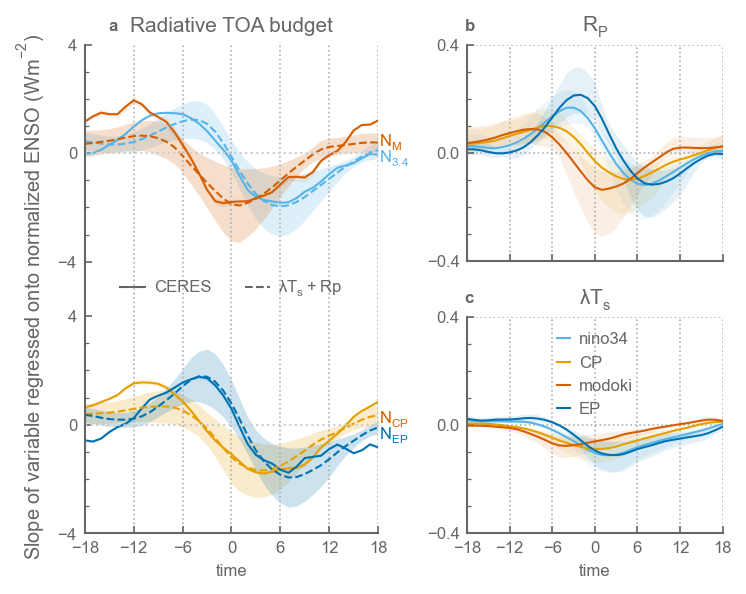

In [39]:
ds_ceres = xr.open_dataset('/projets/EMC2/data/Observations/EEI/CERES/CERES_EBAF-TOA_Ed4.2.1_Subset_200003-202411.nc')
ds_ceres['time'] = pd.date_range(f'{ds_ceres.time.dt.year.values[0]}-{ds_ceres.time.dt.month.values[0]}', freq='MS', periods=ds_ceres.time.size)
ds_ceres = ds_ceres.sel(time=slice('2000-11', '2024-11')).lntime.climato(trend=False).gtoa_net_all_mon

ds_tas = xr.open_dataset('/projets/EMC2/data/Observations/TAS/HadCRUT.5.0.2.0.analysis.summary_series.global.monthly.nc').tas_mean
ds_tas['time'] = pd.date_range(f'{ds_tas.time.dt.year.values[0]}-{ds_tas.time.dt.month.values[0]}', freq='MS', periods=ds_tas.time.size)
ds_tas = ds_tas.sel(time=ds_ceres.time).lntime.climato(trend=False)


# IPCC estimates for lambda: –1.16 [–1.81 to –0.51] median+90% ci

P95 = -1.81
P5 = -0.51
mu = -1.16

sigma = (P5-P95)/2/1.645
lambda_dist = xr.DataArray(np.random.normal(loc=mu, scale=sigma, size=100), dims=['lbd_sample'], coords=dict(lbd_sample=np.arange(100)))


modes_notrend = (modes_obs.mode_timeseries.sel(time=ds_ceres.time)).lntime.climato(trend=False, mean=False).sel(mode=['nino34','EP','CP', 'modoki'])
ceres_notrend = ds_ceres.sel(time=ds_ceres.time).lntime.climato(trend=False, mean=False)
lbd_tas_notrend = ds_tas.sel(time=ds_ceres.time).lntime.climato(trend=False, mean=False)*lambda_dist
Rp_notrend = Rp_total.sel(time=ds_ceres.time).lntime.climato(trend=False, mean=False)

ds_ceres_lag = xr.concat([xr_linregress(modes_notrend.shift(time=k), ceres_notrend).assign_coords(lag=k) for k in range(-18,19)], dim='lag').slope
ds_temp_lag = xr.concat([xr_linregress(modes_notrend.shift(time=k), lbd_tas_notrend).assign_coords(lag=k) for k in range(-18,19)], dim='lag').slope
ds_pattern_lag = xr.concat([xr_linregress(modes_notrend.shift(time=k), Rp_notrend).assign_coords(lag=k) for k in range(-18,19)], dim='lag').slope
ds_both_lag = xr.concat([xr_linregress(modes_notrend.shift(time=k),lbd_tas_notrend+Rp_notrend).assign_coords(lag=k) for k in range(-18,19)], dim='lag').slope




fig, axs = plt.subplot_mosaic("""
                              AB
                              AC
                              """,figsize=(5,4), sharex=True,)

offset=1


ds_ceres_lag.sel(mode=['nino34','modoki']).rename(lag='time').lntime.plot(hue='mode', ax=axs['A'], shaded_area='quantiles', thick_line='mean', shaded_area_alpha=.1, color=[color_palette_enso[0],color_palette_enso[2]])
# ds_ceres_lag.sel(mode=['CP','EP']).rename(lag='time').lntime.plot(hue='mode', ax=axs['A'], shaded_area='quantiles', thick_line='mean', shaded_area_alpha=.1, color='.7', label=False, line_kwargs=dict(linewidth=.5))

(ds_ceres_lag-offset).sel(mode=['CP','EP']).rename(lag='time').lntime.plot(hue='mode', ax=axs['A'], shaded_area='quantiles', thick_line='mean', shaded_area_alpha=.1, color=[color_palette_enso[1],color_palette_enso[3]])
# (ds_ceres_lag-offset).sel(mode=['nino34','modoki']).rename(lag='time').lntime.plot(hue='mode', ax=axs['A'], shaded_area='quantiles', thick_line='mean', shaded_area_alpha=.1, color='.7', label=False, line_kwargs=dict(linewidth=.5))


(ds_pattern_lag+ds_temp_lag).sel(mode=['nino34','modoki']).rename(lag='time').lntime.plot(hue='mode', ax=axs['A'], thick_line='mean',  color=[color_palette_enso[0],color_palette_enso[2]],line_kwargs=dict(ls='--'))
((ds_pattern_lag-offset)+ds_temp_lag).sel(mode=['CP','EP']).rename(lag='time').lntime.plot(hue='mode', ax=axs['A'], thick_line='mean',  color=[color_palette_enso[1],color_palette_enso[3]],line_kwargs=dict(ls='--'))



(ds_pattern_lag).rename(lag='time').sel(mode=['nino34','CP','modoki','EP']).lntime.plot(hue='mode', ax=axs['B'], shaded_area='quantiles', thick_line='mean', shaded_area_alpha=.1,color=color_palette_enso)
(ds_temp_lag).rename(lag='time').sel(mode=['nino34','CP','modoki','EP']).lntime.plot(hue='mode', ax=axs['C'], shaded_area='quantiles', thick_line='mean', shaded_area_alpha=.1,color=color_palette_enso)



axs['A'].text(18.1,-.02,'N$_{3.4}$', ha='left',va='center', color=color_palette_enso[0])
axs['A'].text(18.1,.02-offset,'N$_{CP}$', ha='left',va='center', color=color_palette_enso[2])
axs['A'].text(18.1,-.04-offset,'N$_{EP}$', ha='left',va='center', color=color_palette_enso[3])
axs['A'].text(18.1,.04,'N$_{M}$', ha='left',va='center', color=color_palette_enso[2])

from matplotlib.lines import Line2D


leg = axs['C'].legend()

fig.supylabel(r'Slope of variable regressed onto normalized ENSO (Wm$^{-2}$)')

axs['A'].set_title('Radiative TOA budget')
axs['B'].set_title('$R_P$')
axs['C'].set_title(r'$\lambda T_s$')

for k,ax in enumerate(axs.values()):
    ax.xaxis.set_major_locator(plt.MultipleLocator(6))
    ax.set_ylabel('')

axs['B'].text(-.01, 1.05, 'b', transform=axs['B'].transAxes, ha='left', va='bottom', weight='bold')
axs['C'].text(-.01, 1.05, 'c', transform=axs['C'].transAxes, ha='left', va='bottom', weight='bold')
axs['A'].text(-1.4, 1.05, 'a', transform=axs['B'].transAxes, ha='left', va='bottom', weight='bold')


axs['A'].set_ylim(-1.1,.4)
axs['B'].set_ylim(-.4,.4)
axs['C'].set_ylim(-.4,.4)
axs['C'].set_xlim(-18,18)

axs['A'].set_yticks(list(np.arange(-offset-.4,-offset+.5,.4))+list(np.arange(-.4,+.5,.4)))
axs['A'].yaxis.set_minor_locator(plt.FixedLocator(list(np.arange(-offset-.4,-offset+.5,.1))+list(np.arange(-.4,+.5,.1))))
axs['A'].set_yticklabels([r"$\minus$4",0,4,r"$\minus$4",0,4])
axs['A'].legend().remove()
custom_lines = [Line2D([0], [0], color='.4', lw=1,),
                Line2D([0], [0], color='.4', lw=1, ls='--')]
axs['A'].legend(custom_lines, ['CERES','$\lambda T_s+Rp$'], handlelength=1.5, loc='center', ncols=2)

axs['A'].grid(axis='y')

axs['B'].yaxis.set_major_locator(plt.MultipleLocator(.4))
axs['C'].yaxis.set_major_locator(plt.MultipleLocator(.4))
axs['B'].yaxis.set_minor_locator(plt.MultipleLocator(.1))
axs['C'].yaxis.set_minor_locator(plt.MultipleLocator(.1))
axs['A'].axhline(0, ls=':', color='.8')
axs['A'].axhline(-offset, ls=':', color='.8')
axs['B'].legend().remove()
axs['B'].set_xlabel('')
plt.tight_layout()


pos_A = axs["A"].get_position()


axs["A"].set_position([pos_A.x0-.05, pos_A.y0, pos_A.width+.05, pos_A.height])

plt.savefig('plots/compare_with_ceres_lag_corr.pdf')

# Supplementary figure

## Figure S1: Compare Rp ratio for all ocean basins

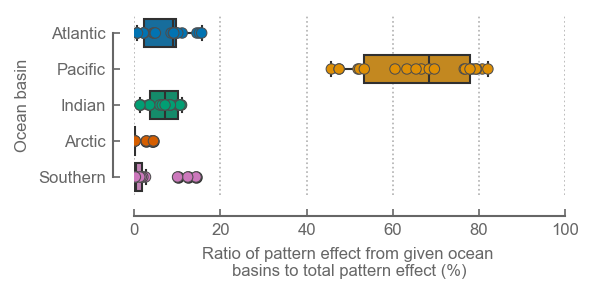

In [40]:
df_ = (100*Rp_all_basins.var('time')/Rp_total.var('time')).rename('Variance_Rp').to_series().reset_index()
sns.catplot(df_, x='Variance_Rp', hue='open_ocean',y='open_ocean', kind='box', height=2, aspect=2)
sns.stripplot(df_, x='Variance_Rp', hue='open_ocean',y='open_ocean',jitter=False, edgecolor='.3', linewidth=.5)
plt.xlim(0,100)
plt.xlabel('Ratio of pattern effect from given ocean \nbasins to total pattern effect (%)')
plt.ylabel('Ocean basin')
sns.despine(trim=True, offset=10,)
plt.tight_layout()
plt.savefig('plots_SI/Rp_with_ocean_basins.svg')

## Figure S2: All EOFs temperature patterns.

Text(0.1, 0.16999999999999993, 'HadISST')

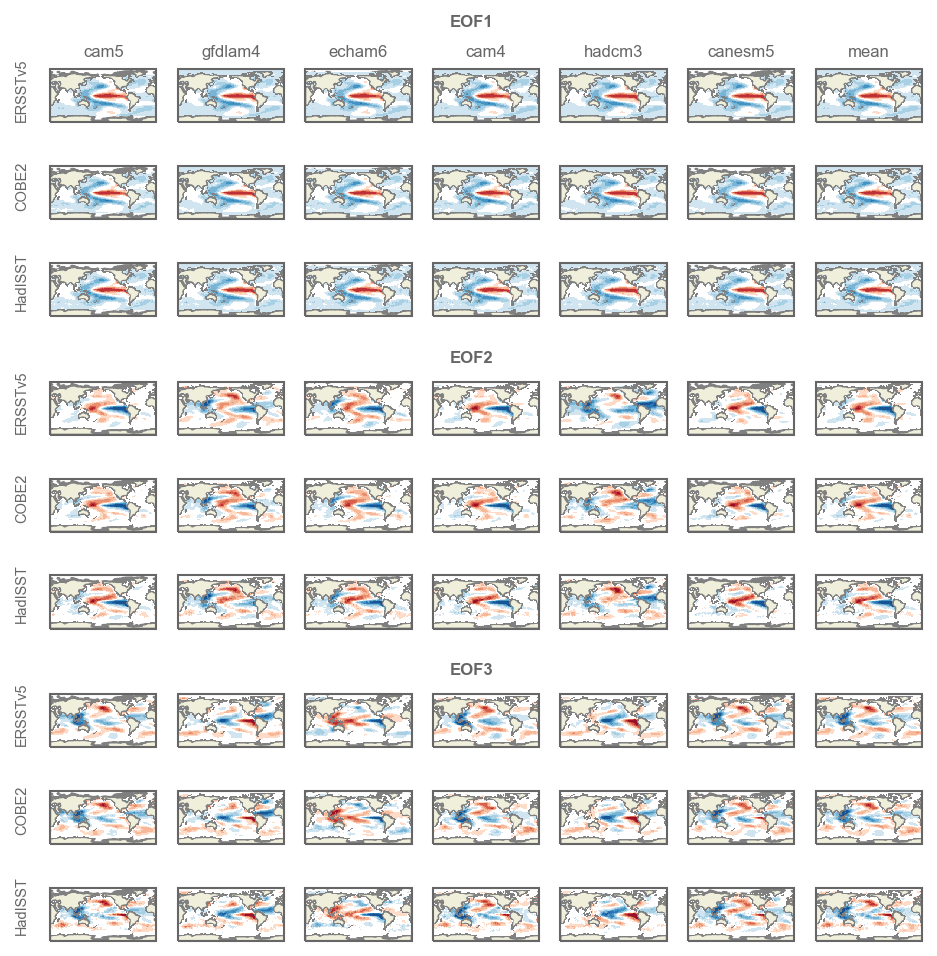

In [43]:
fig, axs = plt.subplot_mosaic(np.transpose([['EOF1-1-1','EOF1-1-2','EOF1-1-3','.','EOF2-1-1','EOF2-1-2','EOF2-1-3','.','EOF3-1-1','EOF3-1-2','EOF3-1-3','.'],
                                            ['EOF1-2-1','EOF1-2-2','EOF1-2-3','.','EOF2-2-1','EOF2-2-2','EOF2-2-3','.','EOF3-2-1','EOF3-2-2','EOF3-2-3','.'],
                                            ['EOF1-3-1','EOF1-3-2','EOF1-3-3','.','EOF2-3-1','EOF2-3-2','EOF2-3-3','.','EOF3-3-1','EOF3-3-2','EOF3-3-3','.'],
                                            ['EOF1-4-1','EOF1-4-2','EOF1-4-3','.','EOF2-4-1','EOF2-4-2','EOF2-4-3','.','EOF3-4-1','EOF3-4-2','EOF3-4-3','.'],
                                            ['EOF1-5-1','EOF1-5-2','EOF1-5-3','.','EOF2-5-1','EOF2-5-2','EOF2-5-3','.','EOF3-5-1','EOF3-5-2','EOF3-5-3','.'],
                                            ['EOF1-6-1','EOF1-6-2','EOF1-6-3','.','EOF2-6-1','EOF2-6-2','EOF2-6-3','.','EOF3-6-1','EOF3-6-2','EOF3-6-3','.'],
                                            ['EOF1-7-1','EOF1-7-2','EOF1-7-3','.','EOF2-7-1','EOF2-7-2','EOF2-7-3','.','EOF3-7-1','EOF3-7-2','EOF3-7-3','.'],
                                ]),
                                height_ratios=[10,10,10,1,10,10,10,1,10,10,10,1],
                                subplot_kw=dict(projection=ccrs.PlateCarree(200)),
                                figsize=(7.5,8), sharex=True, sharey=True)
for feature in range(1,4):
    for GF in range(eofs_pac.GF_source.size):
        for product in range(eofs_pac.product.size):
            ax = axs[f'EOF{feature:.0f}-{GF+1:.0f}-{product+1:.0f}']
            eofs_pac.components_sst.sel(feature=feature).isel(GF_source=GF, product=product).plot(ax=ax, transform=ccrs.PlateCarree(),
                                                              levels=levels_sst, colors=palette_sst,add_colorbar=False)
            if product==0 and feature==1:
                ax.set_title(f'{eofs_pac.GF_source.isel(GF_source=GF).values}', size=8)
            else:
                ax.set_title('')
            if GF_source==0:
                ax.text(0.5,0.5,f'{eofs_pac.product.isel(product=product).values}', transform=ax.transAxes, size=8, ha='left', rotation=90)
            ax.add_feature(cfeat.LAND, edgecolor='.5')

fig.text(0.5,.9,'EOF1', ha='center',va='bottom', weight='bold')
fig.text(0.5,.62,'EOF2', ha='center',va='bottom', weight='bold')
fig.text(0.5,.36,'EOF3', ha='center',va='bottom', weight='bold')

fig.text(0.1,.85,'ERSSTv5', ha='center',va='center', rotation=90, size=7)
fig.text(0.1,.77,'COBE2', ha='center',va='center', rotation=90, size=7)
fig.text(0.1,.69,'HadISST', ha='center',va='center', rotation=90, size=7)

fig.text(0.1,.85-.26,'ERSSTv5', ha='center',va='center', rotation=90, size=7)
fig.text(0.1,.77-.26,'COBE2', ha='center',va='center', rotation=90, size=7)
fig.text(0.1,.69-.26,'HadISST', ha='center',va='center', rotation=90, size=7)

fig.text(0.1,.85-.52,'ERSSTv5', ha='center',va='center', rotation=90, size=7)
fig.text(0.1,.77-.52,'COBE2', ha='center',va='center', rotation=90, size=7)
fig.text(0.1,.69-.52,'HadISST', ha='center',va='center', rotation=90, size=7)

# plt.savefig('plots_SI/all_eofs_patterns.svg')

## Figure S3: All PLSR temperature patterns.

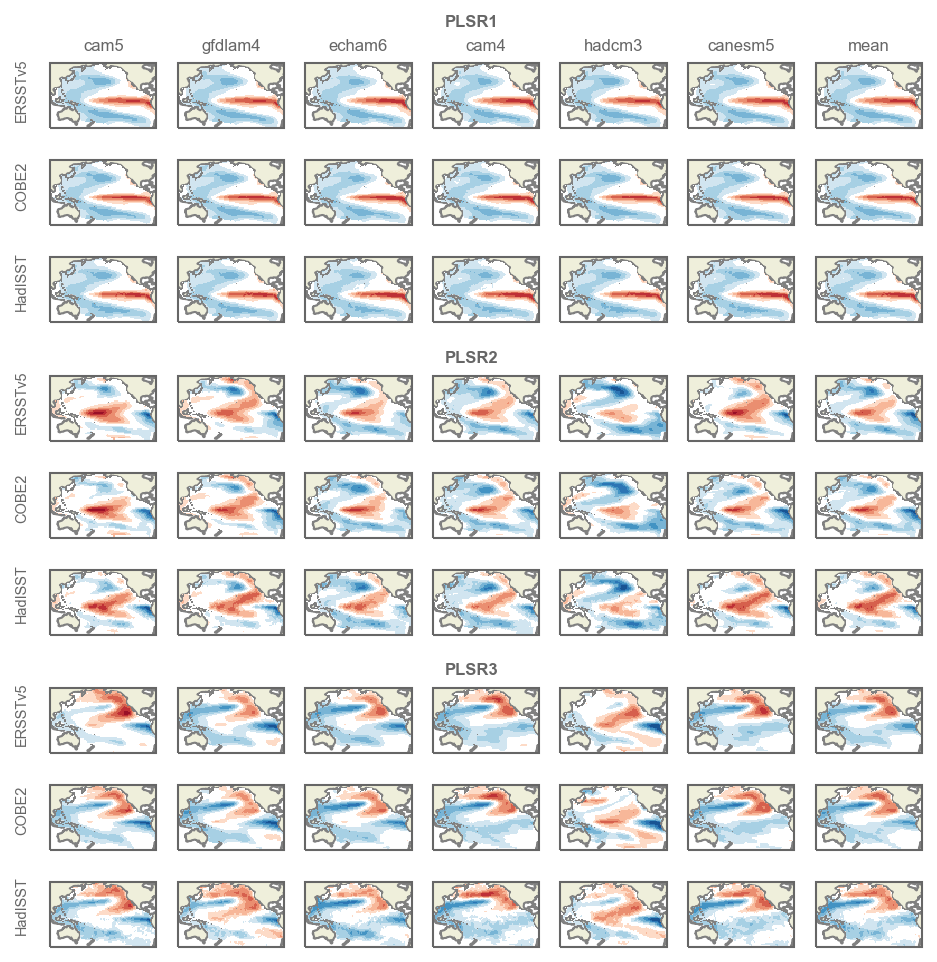

In [42]:
fig, axs = plt.subplot_mosaic(np.transpose([['PLSR1-1-1','PLSR1-1-2','PLSR1-1-3','.','PLSR2-1-1','PLSR2-1-2','PLSR2-1-3','.','PLSR3-1-1','PLSR3-1-2','PLSR3-1-3','.'],
                                            ['PLSR1-2-1','PLSR1-2-2','PLSR1-2-3','.','PLSR2-2-1','PLSR2-2-2','PLSR2-2-3','.','PLSR3-2-1','PLSR3-2-2','PLSR3-2-3','.'],
                                            ['PLSR1-3-1','PLSR1-3-2','PLSR1-3-3','.','PLSR2-3-1','PLSR2-3-2','PLSR2-3-3','.','PLSR3-3-1','PLSR3-3-2','PLSR3-3-3','.'],
                                            ['PLSR1-4-1','PLSR1-4-2','PLSR1-4-3','.','PLSR2-4-1','PLSR2-4-2','PLSR2-4-3','.','PLSR3-4-1','PLSR3-4-2','PLSR3-4-3','.'],
                                            ['PLSR1-5-1','PLSR1-5-2','PLSR1-5-3','.','PLSR2-5-1','PLSR2-5-2','PLSR2-5-3','.','PLSR3-5-1','PLSR3-5-2','PLSR3-5-3','.'],
                                            ['PLSR1-6-1','PLSR1-6-2','PLSR1-6-3','.','PLSR2-6-1','PLSR2-6-2','PLSR2-6-3','.','PLSR3-6-1','PLSR3-6-2','PLSR3-6-3','.'],
                                            ['PLSR1-7-1','PLSR1-7-2','PLSR1-7-3','.','PLSR2-7-1','PLSR2-7-2','PLSR2-7-3','.','PLSR3-7-1','PLSR3-7-2','PLSR3-7-3','.'],
                                ]),
                                height_ratios=[10,10,10,1,10,10,10,1,10,10,10,1],
                                subplot_kw=dict(projection=ccrs.PlateCarree(200)),
                                figsize=(7.5,8), sharex=True, sharey=True)
for feature in range(1,4):
    for GF in range(plsr_pac.GF_source.size):
        for product in range(plsr_pac.product.size):
            ax = axs[f'PLSR{feature:.0f}-{GF+1:.0f}-{product+1:.0f}']
            plsr_pac.components_sst.sel(feature=feature).isel(GF_source=GF, product=product).plot(ax=ax, transform=ccrs.PlateCarree(),
                                                              levels=levels_sst, colors=palette_sst,add_colorbar=False)
            if product==0 and feature==1:
                ax.set_title(f'{plsr_pac.GF_source.isel(GF_source=GF).values}', size=8)
            else:
                ax.set_title('')
            if GF_source==0:
                ax.text(0.5,0.5,f'{plsr_pac.product.isel(product=product).values}', transform=ax.transAxes, size=8, ha='left', rotation=90)
            ax.add_feature(cfeat.LAND, edgecolor='.5')

fig.text(0.5,.9,'PLSR1', ha='center',va='bottom', weight='bold')
fig.text(0.5,.62,'PLSR2', ha='center',va='bottom', weight='bold')
fig.text(0.5,.36,'PLSR3', ha='center',va='bottom', weight='bold')

fig.text(0.1,.85,'ERSSTv5', ha='center',va='center', rotation=90, size=7)
fig.text(0.1,.77,'COBE2', ha='center',va='center', rotation=90, size=7)
fig.text(0.1,.69,'HadISST', ha='center',va='center', rotation=90, size=7)

fig.text(0.1,.85-.26,'ERSSTv5', ha='center',va='center', rotation=90, size=7)
fig.text(0.1,.77-.26,'COBE2', ha='center',va='center', rotation=90, size=7)
fig.text(0.1,.69-.26,'HadISST', ha='center',va='center', rotation=90, size=7)

fig.text(0.1,.85-.52,'ERSSTv5', ha='center',va='center', rotation=90, size=7)
fig.text(0.1,.77-.52,'COBE2', ha='center',va='center', rotation=90, size=7)
fig.text(0.1,.69-.52,'HadISST', ha='center',va='center', rotation=90, size=7)

plt.savefig('plots_SI/all_plsr_patterns.svg')

## Figure S4: Reproduced analysis with the global ocean.

To reproduce this figure, rerun the notebook by changing SSTA_pac by SSTA_detrend and Rp_pac by Rp_total in the processing. That can be done by adding two lines before the EOF and PLSR analysis:

SSTA_pac = SSTA_detrend

Rp_pac = Rp_total

Or by renaming these variables during the processing.

## Figure S5: compare pattern differences

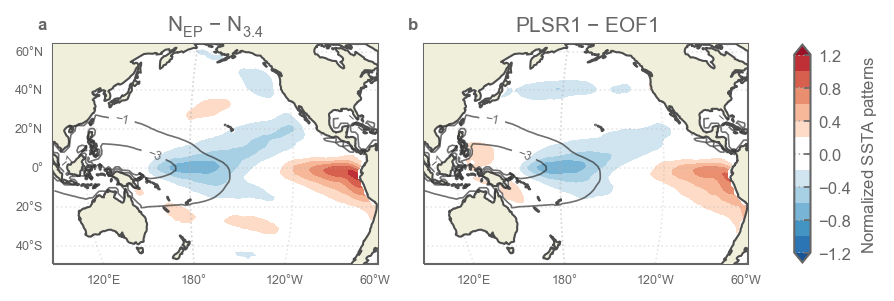

In [43]:

fig, axs = plt.subplot_mosaic("""
                              ABx
                              """,
                              figsize=(6,2),
                              width_ratios=[20,20,1],
                              per_subplot_kw=dict(AB=dict(projection=ccrs.Robinson(200))))

palette_sst=sns.color_palette('RdBu_r',n_colors=14)
palette_sst[6] = (1,1,1)
palette_sst[7] = (1,1,1)



levels_sst = np.arange(-1.2,1.3,.2) 

plsr1 = plsr_pac.components_sst.isel(feature=0).mean(['GF_source','product'])
eof1 = eofs_pac.components_sst.isel(feature=0).mean(['GF_source','product'])
diff_enso = (modes_pattern_mean.sel(mode='EP') - modes_pattern_mean.sel(mode='nino34'))
diff_feature1 = (plsr1-eof1)

diff_enso.plot.contourf(ax=axs['A'], cbar_ax=axs['x'], levels=levels_sst, colors=palette_sst, extend='both', transform=ccrs.PlateCarree())
diff_feature1.plot.contourf(ax=axs['B'], cbar_ax=axs['x'], levels=levels_sst, colors=palette_sst, extend='both', transform=ccrs.PlateCarree())



axs['x'].set_yticks(np.arange(-1.2,1.3,.4))
axs['x'].minorticks_off()
axs['x'].set_ylabel(r'Normalized $SSTA$ patterns')


all_axs = ['A','B']
for k,letter in enumerate(all_axs):
    ax=axs[letter]
    ax.add_feature(cfeat.LAND, edgecolor='.3', zorder=100)
    ax.set_title('')
    c = (mean_gf.sel(lon=mean_eofs.lon, lat=mean_eofs.lat)*1000).plot.contour(levels=[-7,-5,-3,-1,1], extend='both', ax=ax, 
                                                                          zorder=1000, colors='.2', transform=ccrs.PlateCarree(),
                                                                          linewidths=.8, linestyles=['-','-','-','-','--'], alpha=.7)
    ax.clabel(c, c.levels, fmt=None, fontsize=6)
    gl = ax.gridlines(draw_labels=True, alpha=.3)
    if True:
        gl.top_labels=False
    if letter not in ['A','D','M','G','J']:
        gl.left_labels=False
    gl.ylabel_style=dict(size=6)
    gl.xlabel_style=dict(size=6)
    label = chr(ord('a')+k)
    ax.text(-.05,1.05, label, weight='bold', ha='left', va='bottom', transform=ax.transAxes)
    ax.set_ylabel('')

axs['A'].set_title('$N_{EP}$ $\minus$ $N_{3.4}$')
axs['B'].set_title('PLSR1 $\minus$ EOF1')
plt.tight_layout()
plt.savefig('plots_SI/S1_comparing_pattern_differences.svg', dpi=300)


## Figure S6: ENSO indices in CP EP space

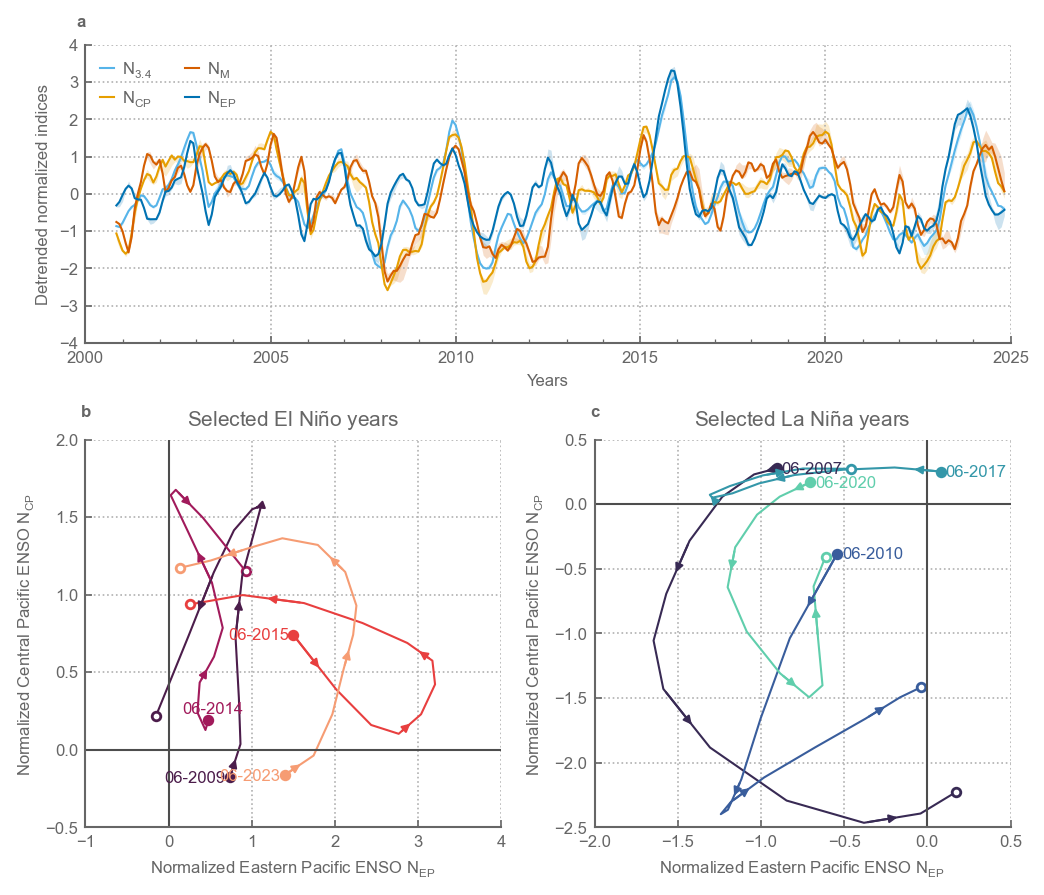

In [44]:
from matplotlib.dates import YearLocator

ninoyears = [2009,2014,2015,2023]
ninayears = [2007,2010,2017,2020]

fig, axs = plt.subplot_mosaic("""
                              CC
                              AB
                              """,
                              figsize = (7,6),
                              height_ratios=(1,1.3))


modes_notrend.sel(mode=['nino34','CP','modoki','EP']).lntime.plot(ax=axs['C'], hue='mode',color=color_palette_enso)
axs['C'].xaxis.set_major_locator(YearLocator(5))
axs['C'].xaxis.set_minor_locator(YearLocator(1))
axs['C'].set_xlim(pd.to_datetime(('2000','2025')))
axs['C'].set_ylim(-4,4)
axs['C'].set_title('')
axs['C'].set_xlabel('Years')
axs['C'].set_ylabel('Detrended normalized indices')

axs['C'].legend(["$N_{3.4}$","$N_{CP}$","$N_{M}$","$N_{EP}$", ], ncols=2)




ninocolors = sns.color_palette('rocket', n_colors=len(ninoyears))
for k,year in enumerate(ninoyears):
    df_ = modes_notrend.rolling(time=3,center=True).mean().sel(time=slice(f"{year}-06",f"{year+1}-05")).mean('product').to_series().unstack().T
    df_.plot.line(x='EP',y='CP', ax=axs['A'], label=year, color=ninocolors[k], legend=False)
    df_.iloc[-1:].plot.scatter(x='EP',y='CP', ax=axs['A'], s=3, color='white', zorder=100)
    df_.iloc[::df_.index.size-1].plot.scatter(x='EP',y='CP', ax=axs['A'],  color=ninocolors[k])
    df_['dx']=df_.EP.diff().shift(-1)
    df_['dy']=df_.CP.diff().shift(-1)
    df_traj = df_.iloc[::3]
    for i in range(0, df_traj.index.size):
        axs['A'].annotate("", xytext=(df_traj.EP.iloc[i], df_traj.CP.iloc[i]), xy=(df_traj.EP.iloc[i] + df_traj.dx.iloc[i]/1.5, df_traj.CP.iloc[i]+ df_traj.dy.iloc[i]/1.5),
            arrowprops=dict(arrowstyle="-|>", color=ninocolors[k]),)
    if year==2014:
        axs['A'].text(df_.iloc[0].EP+.05,df_.iloc[0].CP+.02,f"06-{year}", va='bottom', ha='center',color=ninocolors[k], zorder=100)
    else:
        axs['A'].text(df_.iloc[0].EP-.05,df_.iloc[0].CP-.005,f"06-{year}", va='center', ha='right',color=ninocolors[k], zorder=100)
    # axs['C'].axvline(pd.to_datetime(f"06-{year}"), color=ninocolors[k])


ninacolors = sns.color_palette('mako', n_colors=len(ninayears))
for k,year in enumerate(ninayears):
    df_ = modes_notrend.rolling(time=3,center=True).mean().sel(time=slice(f"{year}-06",f"{year+1}-05")).mean('product').to_series().unstack().T
    axs['B'].plot(df_.EP, df_.CP, color=ninacolors[k], )
    df_.iloc[-1:].plot.scatter(x='EP',y='CP', ax=axs['B'], s=3, color='white', zorder=100)
    df_.iloc[::df_.index.size-1].plot.scatter(x='EP',y='CP', ax=axs['B'],  color=ninacolors[k], legend=False)
    df_['dx']=df_.EP.diff().shift(-1)
    df_['dy']=df_.CP.diff().shift(-1)
    df_traj = df_.iloc[::3]
    for i in range(0, df_traj.index.size):
        axs['B'].annotate("", xytext=(df_traj.EP.iloc[i], df_traj.CP.iloc[i]), xy=(df_traj.EP.iloc[i] + df_traj.dx.iloc[i]/1.5, df_traj.CP.iloc[i]+ df_traj.dy.iloc[i]/1.5),
            arrowprops=dict(arrowstyle="-|>", color=ninacolors[k]),)
    # axs['C'].axvline(pd.to_datetime(f"06-{year}"), color=ninacolors[k])
    axs['B'].text(df_.EP.iloc[0]+.03,df_.CP.iloc[0]-.005,f"06-{year}", va='center', color=ninacolors[k])
# axs['B'].get_legend().remove()
# axs['A'].legend().remove()

axs['A'].axhline(0, color='.3')
axs['A'].axvline(0, color='.3')
axs['B'].axhline(0, color='.3')
axs['B'].axvline(0, color='.3')
axs['A'].set(xlim=(-1,4), ylim=(-.5,2), xlabel='Normalized Eastern Pacific ENSO $N_{EP}$ ', ylabel='Normalized Central Pacific ENSO $N_{CP}$ ', title='Selected El $Ni\~no$ years')
axs['B'].set(xlim=(-2,.5), ylim=(-2.5,.5), xlabel='Normalized Eastern Pacific ENSO $N_{EP}$ ', ylabel='Normalized Central Pacific ENSO $N_{CP}$ ', title='Selected La $Ni\~na$ years')

axs['A'].text(-.01, 1.05, 'b', transform=axs['A'].transAxes, ha='left', va='bottom', weight='bold')
axs['B'].text(-.01, 1.05, 'c', transform=axs['B'].transAxes, ha='left', va='bottom', weight='bold')
axs['C'].text(-.01, 1.05, 'a', transform=axs['C'].transAxes, ha='left', va='bottom', weight='bold')

plt.tight_layout()
plt.savefig('plots_SI/BONUS_ENSO_cycles.pdf', dpi=300)


# Supplementary tables

## Table S1: correlations of modes with EOF1

In [171]:
df_ = df_regr_all.query("feature=='Feature 1' & method =='EOFs' & mode.isin(['nino34','modoki','CP','EP'])")
(df_.pivot(columns='mode', index=['GF_source','product'], values=['regr_space','regr_time'])**2).round(2)

regr_space              regr_time             
mode                      CP    EP nino34        CP    EP nino34
GF_source product                                               
cam4      COBE2         0.86  0.84   0.97      0.67  0.39   0.80
          ERSSTv5       0.84  0.82   0.96      0.66  0.36   0.75
          HadISST       0.80  0.87   0.98      0.58  0.46   0.84
cam5      COBE2         0.86  0.84   0.97      0.68  0.40   0.82
          ERSSTv5       0.85  0.82   0.96      0.68  0.37   0.78
          HadISST       0.81  0.87   0.98      0.60  0.46   0.86
canesm5   COBE2         0.74  0.94   1.00      0.43  0.67   0.92
          ERSSTv5       0.71  0.94   0.99      0.40  0.66   0.89
          HadISST       0.67  0.96   0.99      0.33  0.75   0.92
echam6    COBE2         0.86  0.85   0.97      0.65  0.42   0.84
          ERSSTv5       0.84  0.84   0.97      0.64  0.40   0.80
          HadISST       0.81  0.86   0.98      0.60  0.46   0.85
gfdlam4   COBE2         0.74  0.93   0.99      0.39  0.65   0.88
          ERSSTv5       0.71  0.93   0.99      0.37  0.64   0.85
          HadISST       0.68  0.95   0.99      0.32  0.72   0.90
hadcm3    COBE2         0.70  0.96   0.99      0.30  0.72   0.87
          ERSSTv5       0.65  0.96   0.99      0.25  0.73   0.84
          HadISST       0.65  0.96   0.99      0.26  0.75   0.87
mean      COBE2         0.85  0.85   0.98      0.65  0.43   0.83
          ERSSTv5       0.83  0.84   0.97      0.63  0.40   0.78
          HadISST       0.79  0.88   0.98      0.56  0.50   0.86

## Table S2: correlations of modes with EOF2

In [87]:
df_ = df_regr_all.query("feature=='Feature 2' & method =='EOFs' & mode.isin(['nino34','CP','EP'])")
df_.pivot(columns='mode', index=['GF_source','product'], values=['regr_space','regr_time'])**2

regr_space                     regr_time            \
mode                         CP        EP    nino34        CP        EP   
GF_source product                                                         
cam4      COBE2    1.574154e-02  0.567796  0.349762  0.198962  0.275131   
          ERSSTv5  1.765732e-02  0.615428  0.392682  0.206417  0.272213   
          HadISST  7.563137e-04  0.445940  0.245649  0.256288  0.230664   
cam5      COBE2    2.133863e-02  0.588611  0.370044  0.187045  0.305084   
          ERSSTv5  2.668963e-02  0.654297  0.428247  0.198253  0.318513   
          HadISST  8.209339e-07  0.469978  0.267557  0.243134  0.251639   
canesm5   COBE2    7.691129e-02  0.220601  0.057381  0.483817  0.231062   
          ERSSTv5  9.105066e-02  0.236171  0.064046  0.513415  0.232823   
          HadISST  2.032855e-01  0.113558  0.010655  0.588087  0.165047   
echam6    COBE2    1.609163e-02  0.504497  0.316985  0.143347  0.221000   
          ERSSTv5  2.347229e-02  0.566680  0.373602  0.137330  0.228822   
          HadISST  4.940024e-04  0.404339  0.240237  0.149996  0.173882   
gfdlam4   COBE2    9.557785e-03  0.272174  0.120074  0.184894  0.141879   
          ERSSTv5  2.018360e-03  0.347041  0.176932  0.159989  0.152879   
          HadISST  8.055698e-02  0.104213  0.023814  0.195506  0.066317   
hadcm3    COBE2    1.967671e-01  0.069701  0.001172  0.419432  0.111446   
          ERSSTv5  2.054632e-01  0.081126  0.002861  0.426494  0.106802   
          HadISST  2.473034e-01  0.057292  0.000258  0.439923  0.100652   
mean      COBE2    1.175036e-02  0.553873  0.334242  0.214803  0.286230   
          ERSSTv5  1.293226e-02  0.604719  0.377449  0.227602  0.291264   
          HadISST  1.788762e-03  0.430756  0.232007  0.270110  0.233076   

                             
mode                 nino34  
GF_source product            
cam4      COBE2    0.058019  
          ERSSTv5  0.057861  
          HadISST  0.034488  
cam5      COBE2    0.071365  
          ERSSTv5  0.076392  
          HadISST  0.042408  
canesm5   COBE2    0.000910  
          ERSSTv5  0.000989  
          HadISST  0.002344  
echam6    COBE2    0.056415  
          ERSSTv5  0.061400  
          HadISST  0.038526  
gfdlam4   COBE2    0.012810  
          ERSSTv5  0.018289  
          HadISST  0.000385  
hadcm3    COBE2    0.003818  
          ERSSTv5  0.003765  
          HadISST  0.004909  
mean      COBE2    0.055597  
          ERSSTv5  0.057255  
          HadISST  0.031210

## Table S3: correlations of modes with EOF3

In [88]:
df_ = df_regr_all.query("feature=='Feature 3' & method =='EOFs' & mode.isin(['nino34','CP','EP'])")
df_.pivot(columns='mode', index=['GF_source','product'], values=['regr_space','regr_time'])**2

regr_space                         regr_time                \
mode                      CP            EP    nino34        CP            EP   
GF_source product                                                              
cam4      COBE2     0.193606  2.177109e-01  0.248999  0.033335  8.765737e-03   
          ERSSTv5   0.204549  2.633748e-01  0.287984  0.028907  1.360521e-02   
          HadISST   0.111864  2.040929e-02  0.050535  0.053161  1.044332e-03   
cam5      COBE2     0.115070  8.526335e-02  0.114106  0.031359  9.724583e-04   
          ERSSTv5   0.156637  1.798108e-01  0.203716  0.025060  5.592692e-03   
          HadISST   0.066524  2.582938e-04  0.006324  0.045754  6.635472e-03   
canesm5   COBE2     0.036122  4.313192e-03  0.017400  0.022231  1.670477e-03   
          ERSSTv5   0.061177  3.650767e-02  0.054264  0.021109  8.235495e-07   
          HadISST   0.017721  2.094982e-04  0.005081  0.013858  2.425607e-03   
echam6    COBE2     0.023064  5.774564e-02  0.012666  0.108241  3.436245e-02   
          ERSSTv5   0.035728  4.540275e-02  0.007985  0.126674  3.337617e-02   
          HadISST   0.010471  1.832660e-01  0.079964  0.140966  8.158511e-02   
gfdlam4   COBE2     0.285363  1.038800e-02  0.014297  0.374389  5.617777e-02   
          ERSSTv5   0.250539  3.798982e-02  0.000943  0.431167  7.839669e-02   
          HadISST   0.203818  7.205868e-02  0.002395  0.409522  9.858899e-02   
hadcm3    COBE2     0.103259  1.903129e-10  0.015926  0.110821  3.077045e-03   
          ERSSTv5   0.352822  2.148529e-02  0.099855  0.224144  9.004142e-03   
          HadISST   0.094909  2.443431e-02  0.000046  0.126790  2.674387e-02   
mean      COBE2     0.146223  8.899305e-02  0.127661  0.047431  4.616950e-04   
          ERSSTv5   0.164915  1.404812e-01  0.175044  0.043730  2.335354e-03   
          HadISST   0.064441  3.772542e-03  0.001995  0.071013  1.245063e-02   

                             
mode                 nino34  
GF_source product            
cam4      COBE2    0.035940  
          ERSSTv5  0.038194  
          HadISST  0.011629  
cam5      COBE2    0.017527  
          ERSSTv5  0.023112  
          HadISST  0.003226  
canesm5   COBE2    0.012943  
          ERSSTv5  0.010612  
          HadISST  0.007519  
echam6    COBE2    0.000537  
          ERSSTv5  0.000591  
          HadISST  0.002620  
gfdlam4   COBE2    0.015629  
          ERSSTv5  0.009180  
          HadISST  0.004097  
hadcm3    COBE2    0.022317  
          ERSSTv5  0.029636  
          HadISST  0.004938  
mean      COBE2    0.020728  
          ERSSTv5  0.022787  
          HadISST  0.003165

## Table S4: correlations of modes with PLSR1

In [89]:
df_ = df_regr_all.query("feature=='Feature 1' & method =='PLSR' & mode.isin(['nino34','CP','EP'])")
df_.pivot(columns='mode', index=['GF_source','product'], values=['regr_space','regr_time'])**2

regr_space                     regr_time                    
mode                      CP        EP    nino34        CP        EP    nino34
GF_source product                                                             
cam4      COBE2     0.570921  0.992326  0.960591  0.102073  0.904389  0.802413
          ERSSTv5   0.527563  0.991612  0.958244  0.083028  0.896639  0.789402
          HadISST   0.521226  0.995046  0.961474  0.084657  0.920606  0.814990
cam5      COBE2     0.650330  0.971044  0.980145  0.190391  0.838820  0.860799
          ERSSTv5   0.613902  0.968102  0.979719  0.172501  0.825934  0.854142
          HadISST   0.598703  0.977948  0.981881  0.165744  0.862620  0.874266
canesm5   COBE2     0.608552  0.984685  0.971829  0.146158  0.880276  0.840367
          ERSSTv5   0.564928  0.983854  0.969537  0.123512  0.872364  0.827822
          HadISST   0.556974  0.988626  0.972107  0.121418  0.898776  0.847798
echam6    COBE2     0.545221  0.989720  0.945736  0.068170  0.879693  0.725579
          ERSSTv5   0.502506  0.987611  0.942765  0.054399  0.868947  0.714049
          HadISST   0.495940  0.995426  0.949823  0.056760  0.913398  0.759899
gfdlam4   COBE2     0.667762  0.967273  0.985255  0.228367  0.820442  0.888009
          ERSSTv5   0.620785  0.968137  0.982774  0.194453  0.818978  0.872776
          HadISST   0.607304  0.976595  0.984759  0.184036  0.854554  0.890263
hadcm3    COBE2     0.673672  0.957346  0.979357  0.223591  0.790048  0.851938
          ERSSTv5   0.623443  0.960246  0.977694  0.189448  0.794059  0.845482
          HadISST   0.603777  0.972970  0.979670  0.173109  0.840512  0.860791
mean      COBE2     0.618427  0.981787  0.974013  0.153207  0.869971  0.841880
          ERSSTv5   0.575947  0.980755  0.972206  0.131101  0.861799  0.830724
          HadISST   0.562681  0.987793  0.973991  0.125253  0.894880  0.850832

## Table S5: correlations of modes with PLSR2

In [90]:
df_ = df_regr_all.query("feature=='Feature 2' & method =='PLSR' & mode.isin(['nino34','CP','EP'])")
df_.pivot(columns='mode', index=['GF_source','product'], values=['regr_space','regr_time'])**2

regr_space                     regr_time                    
mode                      CP        EP    nino34        CP        EP    nino34
GF_source product                                                             
cam4      COBE2     0.776915  0.128057  0.322965  0.698273  0.006920  0.137400
          ERSSTv5   0.782394  0.132468  0.327046  0.686393  0.005439  0.138241
          HadISST   0.780399  0.118341  0.298675  0.689679  0.006807  0.121394
cam5      COBE2     0.554806  0.038853  0.168678  0.567612  0.019371  0.088698
          ERSSTv5   0.523140  0.038505  0.157101  0.530967  0.015991  0.080470
          HadISST   0.578898  0.017906  0.125039  0.623245  0.033197  0.068100
canesm5   COBE2     0.684052  0.051225  0.208877  0.678205  0.023549  0.103360
          ERSSTv5   0.704821  0.049267  0.206025  0.686544  0.021995  0.103741
          HadISST   0.710337  0.046617  0.193237  0.703936  0.024187  0.092738
echam6    COBE2     0.845174  0.280625  0.500333  0.651830  0.003779  0.226988
          ERSSTv5   0.818683  0.285564  0.497637  0.624634  0.005818  0.229193
          HadISST   0.840884  0.229587  0.435252  0.671491  0.000515  0.186060
gfdlam4   COBE2     0.413249  0.009944  0.092579  0.400763  0.022800  0.050853
          ERSSTv5   0.430299  0.015386  0.102809  0.395672  0.019583  0.050900
          HadISST   0.488491  0.010002  0.093550  0.474294  0.033016  0.041296
hadcm3    COBE2     0.359833  0.180353  0.277070  0.185953  0.004992  0.092338
          ERSSTv5   0.393849  0.170159  0.273044  0.195805  0.003041  0.079387
          HadISST   0.469643  0.157684  0.277559  0.243611  0.000427  0.078660
mean      COBE2     0.663815  0.061490  0.219976  0.627582  0.017531  0.101845
          ERSSTv5   0.665205  0.064292  0.219943  0.611018  0.014824  0.099408
          HadISST   0.687492  0.054523  0.200761  0.651200  0.020219  0.087405

## Table S6: correlations of modes with PLSR3

In [ ]:
df_ = df_regr_all.query("feature=='Feature 3' & method =='PLSR' & mode.isin(['nino34','modoki','CP','EP'])")
df_.pivot(columns='mode', index=['GF_source','product'], values=['regr_space','regr_time'])**2

regr_space                                regr_time  \
mode                      CP        EP modoki_eof    nino34        CP   
GF_source product                                                       
cam4      COBE2     0.062169  0.002297   0.166687  0.002390  0.000058   
          ERSSTv5   0.088581  0.003077   0.217354  0.003732  0.002435   
          HadISST   0.062895  0.000923   0.142566  0.003341  0.000077   
cam5      COBE2     0.160125  0.019759   0.534854  0.001454  0.090214   
          ERSSTv5   0.200429  0.021090   0.596960  0.002377  0.108029   
          HadISST   0.155297  0.012220   0.429318  0.001911  0.050789   
canesm5   COBE2     0.047371  0.005305   0.144407  0.000258  0.000285   
          ERSSTv5   0.059334  0.005956   0.163215  0.000570  0.000650   
          HadISST   0.042516  0.002840   0.107353  0.000441  0.000068   
echam6    COBE2     0.171992  0.003321   0.417469  0.009912  0.061169   
          ERSSTv5   0.197408  0.003218   0.433595  0.011812  0.063323   
          HadISST   0.179313  0.000808   0.363169  0.012979  0.042521   
gfdlam4   COBE2     0.174541  0.020512   0.554252  0.001646  0.130031   
          ERSSTv5   0.184002  0.019945   0.523366  0.001796  0.120407   
          HadISST   0.182571  0.011401   0.474898  0.003403  0.099264   
hadcm3    COBE2     0.221654  0.018909   0.675391  0.005499  0.196170   
          ERSSTv5   0.271991  0.026891   0.784173  0.003859  0.260099   
          HadISST   0.297628  0.019864   0.781598  0.005400  0.309422   
mean      COBE2     0.106743  0.009545   0.322468  0.001572  0.026629   
          ERSSTv5   0.130679  0.010579   0.356920  0.002262  0.034305   
          HadISST   0.103341  0.004603   0.255613  0.002589  0.015511   

                                                      
mode                     EP modoki_eof        nino34  
GF_source product                                     
cam4      COBE2    0.006460   0.007038  1.586152e-03  
          ERSSTv5  0.008051   0.020115  5.588595e-04  
          HadISST  0.002501   0.004509  2.360492e-04  
cam5      COBE2    0.054429   0.223245  2.063846e-05  
          ERSSTv5  0.055022   0.263751  1.146073e-04  
          HadISST  0.034112   0.121914  7.331641e-04  
canesm5   COBE2    0.009772   0.005182  5.385025e-03  
          ERSSTv5  0.009572   0.008120  3.690229e-03  
          HadISST  0.003653   0.000487  3.415164e-03  
echam6    COBE2    0.040433   0.131011  3.369176e-04  
          ERSSTv5  0.038938   0.136105  3.198175e-04  
          HadISST  0.023345   0.081919  1.240171e-04  
gfdlam4   COBE2    0.073681   0.269703  6.571272e-05  
          ERSSTv5  0.064364   0.251417  2.814049e-05  
          HadISST  0.045841   0.186873  2.202582e-09  
hadcm3    COBE2    0.056668   0.360202  8.559828e-03  
          ERSSTv5  0.076124   0.488888  6.360261e-03  
          HadISST  0.095511   0.503495  2.054375e-03  
mean      COBE2    0.029099   0.075315  1.359146e-03  
          ERSSTv5  0.029261   0.094721  5.302292e-04  
          HadISST  0.014910   0.040165  7.385203e-04

# Test warmpool

<Axes: xlabel='False', ylabel='True'>

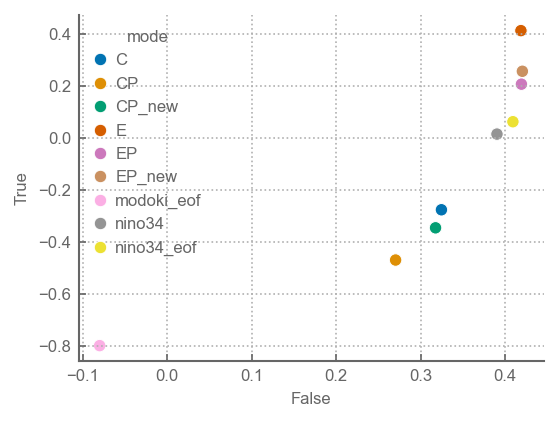

In [142]:
wp = ds_tos.mean('product').mean('time').sel(lat=slice(30,-30)).stack(space=['lat','lon']).rank('space',pct=True).unstack()>.7


df_ = xr.Dataset(dict(modes=((modes_obs.mode_pattern/modes_obs.lambdas_space)*GF).sel(lat=slice(30,-30)).mean(['product','GF_source']), wp=wp)).to_dataframe().reset_index()
sns.scatterplot(df_.groupby(['mode','wp']).sum().modes.unstack(), x=False,y=True, hue='mode')